<a id='top'></a>

# PCA and K-Means Clustering of 'Piqué-like' Defenders for Parma Calcio 1913
##### Data analysis notebook to cluster player performance data from [FBref](https://fbref.com/en/) via [StatsBomb](https://statsbomb.com/) 

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 29/10/2021<br>
Notebook last updated: 04/11/2021

![StatsBomb](../../../img/logos/stats-bomb-logo.png)

![Parma Calcio 1913](../../../img/club_badges/parma_badge_banner.jpeg)

Click [here](#section8) to jump straight to the Recruitment Analysis section and skip the [Notebook Brief](#section2), [Data Sources](#section3), [Data Engineering](#section4), [Machine Learning](#section5), [Data Visualisation](#section6), [Data Analysis](#section7) sections, and [Recruitment Analysis](#section8) sections. Or skip straight to the [Summary](#section9).

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook analyses an engineered dataset of aggregated player performance from [FBref](https://fbref.com/en/) via [StatsBomb](https://statsbomb.com/), enriched with player bio and valuation data from [TransferMarkt](https://www.transfermarkt.co.uk/) and player salaries data from [Capology](https://www.capology.com/), using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames, [matplotlib](https://matplotlib.org/stable/index.html) for data visualisation, and [scikit-learn](https://scikit-learn.org/stable/) for Machine Learning.

For more information about this notebook and the author, I am available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/); and
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster).

![profile](../../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.org/github/eddwebster/football_analytics/blob/master/notebooks/5_data_analysis_and_projects/player_similarity_and_clustering/PCA%20and%20K-Means%20Clustering%20of%20%27Piqu%C3%A9-like%27%20Defenders%20for%20Parma%20Calcio%201913.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Notebook Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Read in the Dataset](#section3.1)<br>
      2.    [Initial Data Handling](#section3.2)<br>
4.    [Data Engineering](#section4)<br>
5.    [Machine Learning](#section5)<br>
      1.    [Principle Component Analysis (PCA)](#section5.1)<br>
      2.    [K-Means Clustering](#section5.2)<br>
6.    [Data Visualisation](#section6)<br>
7.    [Exploratory Data Analysis](#section7)<br>
8.    [Recruitment Analysis](#section8)<br>
9.    [Summary](#section9)<br>
10.    [Next Steps](#section10)<br>
11.    [References](#section11)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations.

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [255]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import pandas_profiling as pp
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno
import soccerplots
from soccerplots.radar_chart import Radar   # for custom radar visuals

# Machine Learning
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Print Statement
print('Setup Complete')

Setup Complete


In [256]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

Python: 3.7.6
NumPy: 1.20.3
pandas: 1.3.2
matplotlib: 3.4.2


### Define Filepaths

In [257]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_fbref = os.path.join(base_dir, 'data', 'fbref')
img_dir = os.path.join(base_dir, 'img')

### Defined Variables

In [258]:
# Defined Bariables

## Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Custom Functions

In [259]:
# Define function for creating a two player radar
def create_2p_radar(df,
                    season='2020/2021',
                    player_1_name='Gerard Pique',
                    player_1_colour='blue', 
                    player_1_team='Barcelona',
                    player_2_name='n/a',
                    player_2_colour='red',
                    player_2_team='n/a'
                   ):
    
    """
    Function to create a two player radar, based on the soccerplots
    library, a Python package that can be used for making visualisations 
    for football analytics by Anmol Durgapal (@slothfulwave612).
    """
    
    ## Select only the players we wish to compare
    lst_players = [player_1_name, player_2_name]

    ## Filter df_radarFrame to only have 
    df_radar = df[(df['player_name_fbref'].isin(lst_players)) &
                  (df['season'] == season)
                 ]

    # Select only columns of interest for radar
    df_radar = df_radar[cols_radar]

    ## Reset index
    df_radar = df_radar.reset_index(drop=True)

    # Get parameters
    params = list(data.columns)
    params = params[2:]
    
    ## Add ranges to list of tuple pairs
    ranges = []
    a_values = []
    b_values = []
    
    ##
    for x in params:
        a = min(df_radar[params][x])
        a = a - (a*.25)

        b = max(df_radar[params][x])
        b = b + (b*.25)

        ranges.append((a, b))

    ##
    for x in range(len(df_radar['player_name_fbref'])):
        if df_radar['player_name_fbref'][x] == player_1_name:
            a_values = df_radar.iloc[x].values.tolist()
        if df_radar['player_name_fbref'][x] == player_2_name:
            b_values = df_radar.iloc[x].values.tolist()
    
    ##
    a_values = a_values[2:]
    b_values = b_values[2:]

    ##
    values = [a_values, b_values]

    ##
    title = dict(
        title_name = player_1_name,
        title_color = player_1_colour,
        subtitle_name = player_1_team,
        subtitle_color = player_1_colour,
        title_name_2 = player_2_name,
        title_color_2 = player_2_colour,
        subtitle_name_2 = player_2_team,
        subtitle_color_2 = player_2_colour,
        title_fontsize = 18,
        subtitle_fontsize=15
    )

    ##
    endnote = '@eddwebster\ndf_radarvia FBref / Statsbomb'

    ##
    radar = Radar()

    ##
    fig, ax = radar.plot_radar(ranges=ranges,
                               params=params,
                               values=values,
                               radar_color=[player_1_colour, player_2_colour],
                               alphas=[.5,.5],
                               title=title,
                               endnote=endnote,
                               compare=True
                              )


### Notebook Settings

In [260]:
# Display all columns of pandas DataFrames
pd.set_option('display.max_columns', None)

---

<a id='section2'></a>

## <a id='#section2'>2. Notebook Brief</a>
This Jupyter notebook is part of a series of notebooks, to scrape, parse, engineer, and unify datasets, culminating with basic modeling, to **find the new Gerard Piqué** for [Parma Calcio 1913](https://parmacalcio1913.com/).

The emailed brief is as follows:
>Using the dataset freely available [here](https://github.com/statsbomb/open-data) or any other source of data you think could be useful.
>
>You will need to explain the process you would use to find the next G. Piqué.
>
>We are looking for a utility player, capable of playing more than 30 games a year, aged less than 23 y.o, that could potentially fit the Parma Calcio team.
>
>[note this is clearly a fictional example].
> 
>Process should be explained using a R Notebook, Jupyter Notebook or Google colab document.cluster player performance data 

![pique](../../../img/pique_parma_banner.jpeg)

This particular notebook is the **Player Similarity** notebook, that takes the engineered data player performance data from [FBref](https://fbref.com/en/) via [StatsBomb](https://statsbomb.com/) for the 'Big 5' European leagues from 17/18-20/21, matched to corresponding estimated values from [TransferMarkt](https://www.transfermarkt.co.uk/) and salaries from [Capology](https://www.capology.com/), to conduct some basic clustering using PCA and K-Means Clustering, to find the players with similar output to Gerard Piqué, in an attempt to find players that as part of a recruitment strategy for Parma Calcio 1913.

Links to these notebooks in the [`football_analytics`](https://github.com/eddwebster/football_analytics) GitHub repository can be found at the following:
*    [1. Webscraping](https://github.com/eddwebster/football_analytics/tree/master/notebooks/1_data_scraping)
     +    [TransferMarket Player Bio and Status Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/TransferMarkt%20Player%20Bio%20and%20Status%20Web%20Scraping.ipynb)
     +    [Capology Player Salary Webscraping](https://github.com/eddwebster/football_analytics/blob/master/notebooks/1_data_scraping/Capology%20Player%20Salary%20Web%20Scraping.ipynb)
*    [2. Data Parsing](https://github.com/eddwebster/football_analytics/tree/master/notebooks/2_data_parsing)
     +    [StatsBomb Data Parsing](https://github.com/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/ELO%20Team%20Ratings%20Data%20Parsing.ipynb)
*    [3. Data Engineering](https://github.com/eddwebster/football_analytics/tree/master/notebooks/3_data_engineering)
     +    [StatsBomb Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/FBref%20Player%20Stats%20Data%20Engineering.ipynb)
     +    [TransferMarket Player Bio and Status Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/TransferMarkt%20Player%20Bio%20and%20Status%20Data%20Engineering.ipynb)
     +    [Capology Player Salary Data Engineering](https://github.com/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Capology%20Player%20Salary%20Data%20Engineering.ipynb)
*    [4. Data Unification](https://github.com/eddwebster/football_analytics/tree/master/notebooks/4_data_unification)
     +  
*    [5. Modeling and Data Analysis](https://github.com/eddwebster/football_analytics/tree/master/notebooks/5_data_analysis_and_projects)
     +    [PCA and K-Means Clustering of 'Piqué-like' Defenders for Parma Calcio 1913](https://github.com/eddwebster/football_analytics/blob/master/notebooks/5_data_analysis_and_projects/player_similarity_and_clustering/PCA%20and%20K-Means%20Clustering%20of%20'Piqu%C3%A9-like'%20Defenders%20for%20Parma%20Calcio%201913.ipynb) (based on FBref aggregated player performance data)

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

<a id='section3.1'></a>

### <a id='#section3.1'>3.1. Data Dictionary</a>
The raw dataset has one hundred and ninety two features (columns) with the following definitions and data types:


| No.     | Variable     | Data Type    | Description    | Stats Type    | Source    |
|------|------|-----|-----|-----|-----|
| 1    | `player_name_fbref`    | object    | **Player's Name**, as per FBref Passing Stats     | FBref Standard Stats    | [FBref](https://fbref.com/)    |
| 2    | `season`    | object   | **Season**.    | Status    | [FBref](https://fbref.com/)    |
| 3    | `url_fbref`    | object   | **FBref URL**    | Status    | [FBref](https://fbref.com/)    |
| 4    | `url_tm`    | object   | **TransferMarkt URL**    | ID    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 5    | `fbref_id`    | object   | **FBref ID**    | ID    | [FBref](https://fbref.com/)    |
| 6    | `tm_id`    | object   | **TransferMarkt ID**    | ID    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 7    | `Squad`    | float64    | **Team/squad name**    | Team     | [FBref](https://fbref.com/)    |
| 8    | `Team Country`    | object   | **Country of the team/league**.    | Team    | [FBref](https://fbref.com/)    |
| 9    | `Comp`    | object   | **Competition**    | Team    | [FBref](https://fbref.com/)    |
| 10    | `Pos`    | float64    | **Position**    | Playing info     | [FBref](https://fbref.com/)    |
| 11    | `Primary Pos`    | object   | **Primary position of the player**.    | Playing info    | [FBref](https://fbref.com/)    |
| 12    | `TmPos`    | object   | **Position**, as per TransferMarkt    | Playing info    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 13    | `Position Grouped`    | object   | **Primary position grouped** - Goalkeeper, Defender, Midfielder, Forward.    | Playing info    | [FBref](https://fbref.com/)    |
| 14    | `outfielder_goalkeeper`    | object   | **Playering position is in goal or outfield**.    | Playing info    | [FBref](https://fbref.com/)    |
| 15    | `Age`    | object   | **Age**    | Player bio    | [FBref](https://fbref.com/)    |
| 16    | `age_when_joining`    | object   | **Age when joining the club**    | Player bio    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 17    | `dob`    | object   | **Date of birth**    |  Player bio   | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 18    | `height`    | object   | **Height**    | Player bio     | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 19    | `foot`    | object   | **Primary foot**    | Player bio    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 20    | `pob`    | object   | **Place of birth**    | Player bio    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 21    | `cob`    | object   | **Country of birth**    | Player bio    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 22    | `Nationality Cleaned`    | object   | **Tidied nationality**, engineered from FBref nationality   | Player bio    | [FBref](https://fbref.com/) 
| 23    | `cityzenship`    | object   | **Cityzenship**    | Player bio    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 24    | `second_cityzenship`    | object   | **Second cityzenship**    | Player bio    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 25    | `market_value_gbp`    | object   | **Estimated Market Value in GBP**    | Valuation    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
|  26     | `market_value_eur`    | object   | **Estimated Market Value in EUR**    | Valuation    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `joined`    | object   | **Date joined current club**    | Contractual status    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `years_since_joining`    | object   | **Years since joining the current club**    | Contractual status    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `years_until_contract_expiry`    | object   | **Years until contract expiry with current club**    | Contractual status    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `contract_expires`    | object   | **Contract expiry**    | Contractual status     | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `contract_option`    | object   | **Contract option**    |  Contractual status    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `on_loan_from`    | object   | **On loan from club**    | Contractual status     | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `on_loan_from_country`    | object   | **Country of the club on loan from**    | Contractual status     | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `loan_contract_expiry`    | object   | **Loan contract expiry**    | Contractual status     | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `weekly_gross_base_salary_gbp`    | object   | **Weekly gross base salary in GBP**    | Salary    | [Capology](https://www.capology.com/)    |
| 1     | `annual_gross_base_salary_gbp`    | object   | **Annual gross base salary in GBP**    | Salary    | [Capology](https://www.capology.com/)    |
| 1     | `adj_current_gross_base_salary_gbp'`    | object   | **Current gross base salary in GBP**    | Salary    | [Capology](https://www.capology.com/)    |
| 1     | `estimated_gross_total_gbp`    | object   | **Estimated gross total salary in GBP**    | Salary    | [Capology](https://www.capology.com/)    |
| 1     | `current_contract_status`    | object   | **Current contract status**    | Contractual status   | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `current_contract_expiration`    | object   | **Current contract expiration**    | Contractual status    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `current_contract_length`    | object   | **Current contract length**    | Contractual status    | [TransferMarkt](https://www.transfermarkt.co.uk/)    |
| 1     | `Comp`    | float64    |     | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `Age`    | float64    | **Current Age**    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `Born`    | float64    | **Year of Birth**    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `MP`    | float64    |  **Matched Played**   | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `Starts`    | float64    |  **Games Started**   | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `Min`    | float64    | **Minutes**    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `90s`    | float64    | **90s Played**. Minutes played divided by 90.     | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `Gls`    | float64    | **Goals**. Goals scored or allowed     | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `Ast`    | float64    | **Assists**     | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `G-PK`    | float64    | **Non-Penalty Goals**     | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `PK`    | float64    | **Penalty Kicks Made**    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `PKatt`    | float64    | **Penalty Kicks Attempted**    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `CrdY`    | float64    | **Yellow Cards**    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `CrdR`    | float64    | **Red Cards**    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `G+A`    | float64    | **Goals Scored per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `G+A-PK`    | float64    | **Goals plus Assists minus Penalty Kicks made per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `xG`    | float64    | **Expected Goals**. xG totals include penalty kicks, but do not include penalty shootouts.     | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `npxG`    | float64    | **Non-Penalty Expected Goals per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader     | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `xA`    | float64    | **xG Assisted**. xG which follows a pass that assists a shot.     | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `npxG+xA`    | float64    | **Non-Penalty Expected Goals plus xG Assisted per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `xG+xA`    | float64    | **Expected Goals plus Assist per 90 minutes**. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted). Minimum 30 minutes played per squad game to qualify as a leader    | FBref Standard Stats     | [FBref](https://fbref.com/)    |
| 1     | `Sh`    | float64    | **Shots Total**. Does not include penalty kicks.    | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `SoT`    | float64    | **Shots on target**. Note: Shots on target do not include penalty kicks.     | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `SoT%`    | float64    | **Shots on target percentage**. Percentage of shots that are on target. Minimum .395 shots per squad game to qualify as a leader. Note: Shots on target do not include penalty kicks    | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `Sh/90`    | float64    | **Shots total per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `SoT/90`    | float64    | **Shots on target per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader. Note: Shots on target do not include penalty kicks    | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `G/Sh`    | float64    | **Goals per shot**. Minimum .395 shots per squad game to qualify as a leader.    | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `G/SoT`    | float64    | **Goals per shot on target**. Minimum .111 shots on target per squad game to qualify as a leader. Note: Shots on target do not include penalty kicks.    | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `Dist`    | float64    | **Average distance, in yards, from goal of all shots taken**. Minimum .395 shots per squad game to qualify as a leader. Does not include penalty kicks.    | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `FK`    | float64    | **Shots from free kicks**.     | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `npxG/Sh`    | float64    | **Non-Penalty Expected Goals per shot**. Minimum .395 shots per squad game to qualify as a leader.    | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `G-xG`    | float64    | **Goals minus Expected Goals**. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).     | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `np:G-xG`    | float64    | **Non-Penalty Goals minus Non-Penalty Expected Goals**. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).     | FBref Shooting Stats     | [FBref](https://fbref.com/)    |
| 1     | `Cmp`    | float64    | **Passes Completed**.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1     | `Att`    | float64    | **Passes Attempted**.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1     | `Cmp%`    | float64    | **Pass Completion Percentage**. Minimum 30 minutes played per squad game to qualify as a leader    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1     | `TotDist`    | float64    | **Total distance, in yards, that completed passes have traveled in any direction**.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1     | `PrgDist`    | float64    | **Progressive Distance**. Total distance, in yards, that completed passes have traveled towards the opponent's goal. Note: Passes away from opponent's goal are counted as zero progressive yards.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1     | `A-xA`    | float64    | **Assists minus xG Assisted**.     | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1     | `KP`    | float64    | **Passes that directly lead to a shot (assisted shots)**.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1     | `1/3`    | float64    | **Completed passes that enter the 1/3 of the pitch closest to the goal**. Not including set pieces.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1    | `PPA`    | float64    | **Completed passes into the 18-yard box**. Not including set pieces.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1    | `CrsPA`    | float64    | **Completed crosses into the 18-yard box**. Not including set pieces.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1    | `Prog`    | float64    | **Progressive Passes**. Completed passes that move the ball towards the opponent's goal at least 10 yards from its furthest point in the last six passes, or any completed pass into the penalty area. Excludes passes from the defending 40% of the pitch     | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1    | `Live`    | float64    | **Live-ball passes**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Dead`    | float64    | **Dead-ball passes**. Includes free kicks, corner kicks, kick offs, throw-ins and goal kicks.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `TB`    | float64    | **Completed pass sent between back defenders into open space**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Press`    | float64    | **Passes made while under pressure from opponent**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Sw`    | float64    | **Passes that travel more than 40 yards of the width of the pitch**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Crs`    | float64    | **Crosses**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `CK`    | float64    | **Corner Kicks**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `In`    | float64    | **Inswinging Corner Kicks**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Out`    | float64    | **Outswinging Corner Kicks**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Str`    | float64    | **Straight Corner Kicks**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Groud`    | float64    | **Ground passes**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Low`    | float64    | **Passes that leave the ground, but stay below shoulder-level**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `High`    | float64    | **Passes that are above shoulder-level at the peak height**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Left`    | float64    | **Passes attempted using left foot**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Right`    | float64    | **Passes attempted using right foot**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Head`    | float64    | **Passes attempted using head**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `TI`    | float64    | **Throw-Ins taken**.    | FBref Pass Type Stats     | [FBref](https://fbref.com/)    |
| 1    | `Other`    | float64    | **Passes attempted using body parts other than the player's head or feet.**    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1    | `Off`    | float64    | **Offsides**.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1     | `Int`    | float64    | **Intercepted**.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1    | `Blocks`    | float64    | **Blocked by the opponent who was standing it the path**.    | FBref Passing Stats     | [FBref](https://fbref.com/)    |
| 1    | `SCA`    | float64    | **Shot-Creating Actions**. The two offensive actions directly leading to a shot, such as passes, dribbles and drawing fouls. Note: A single player can receive credit for multiple actions and the shot-taker can also receive credit.    | FBref Goal and Shot Creation Stats     | [FBref](https://fbref.com/)    |
| 1    | `SCA90`    | float64    | **Shot-Creating Actions per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | FBref Goal and Shot Creation Stats     | [FBref](https://fbref.com/)    |
| 1    | `PassLive`    | float64    | **Completed live-ball passes that lead to a shot attempt**.    | FBref Goal and Shot Creation Stats     | [FBref](https://fbref.com/)    |
| 1    | `PassDead`    | float64    | **Completed dead-ball passes that lead to a shot attempt**. Includes free kicks, corner kicks, kick offs, throw-ins and goal kicks.    | FBref Goal and Shot Creation Stats     | [FBref](https://fbref.com/)    |
| 1    | `Drib`    | float64    | **Successful dribbles that lead to a shot attempt**.    | FBref Goal and Shot Creation Stats     | [FBref](https://fbref.com/)    |
| 1    | `Fld`    | float64    | **Fouls drawn that lead to a shot attempt**.    | FBref Goal and Shot Creation Stats     | [FBref](https://fbref.com/)    |
| 1    | `Def`    | float64    | **Defensive actions that lead to a shot attempt**.    | FBref Goal and Shot Creation Stats     | [FBref](https://fbref.com/)    |
| 1    | `GCA`    | float64    | **Goal-Creating Actions**. The two offensive actions directly leading to a goal, such as passes, dribbles and drawing fouls. Note: A single player can receive credit for multiple actions and the shot-taker can also receive credit.    | FBref Goal and Shot Creation Stats     | [FBref](https://fbref.com/)    |
| 1    | `GCA90`    | float64    | **Goal-Creating Actions per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader.    | FBref Goal and Shot Creation Stats     | [FBref](https://fbref.com/)    |
| 1    | `Tkl`    | float64    | **Number of players tackled**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `TklW`    | float64    | **Tackles in which the tackler's team won possession of the ball**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Def 3rd`    | float64    | **Tackles in defensive 1/3**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Mid 3rd`    | float64    | **Tackles in middle 1/3**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Att 3rd`    | float64    | **Tackles in attacking 1/3**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Tkl%`    | float64    | **Percentage of dribblers tackled**. Dribblers tackled divided by dribblers tackled plus times dribbled past. Minimum .625 dribblers contested per squad game to qualify as a leader.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Past`    | float64    | **Number of times dribbled past by an opposing player**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Succ`    | float64    | **Number of times the squad gained possession withing five seconds of applying pressure**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `%`    | float64    | **Successful Pressure Percentage**. Percentage of time the squad gained possession withing five seconds of applying pressure. Minimum 6.44 pressures per squad game to qualify as a leader    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `ShSv`    | float64    | **Number of times blocking a shot that was on target, by standing in its path**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Pass`    | float64    | **Number of times blocking a pass by standing in its path**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Tkl+Int`    | float64    | **Number of players tackled plus number of interceptions**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Clr`    | float64    | **Clearances**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Err`    | float64    | **Mistakes leading to an opponent's shot**.    | FBref Defensive Action Stats     | [FBref](https://fbref.com/)    |
| 1    | `Touches`    | float64    | **Number of times a player touched the ball**. Note: Receiving a pass, then dribbling, then sending a pass counts as one touch.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Def Pen`    | float64    | **Touches in defensive penalty area**.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Att Pen`    | float64    | **Touches in attacking penalty area**.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Succ%`    | float64    | **Percentage of Dribbles Completed Successfully**. Minimum .5 dribbles per squad game to qualify as a leader    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `#Pl`    | float64    | **Number of Players Dribbled Past**.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Megs`    | float64    | **Number of times a player dribbled the ball through an opposing player's legs**.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Carries`    | float64    | **Number of times the player controlled the ball with their feet**.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `CPA`    | float64    | **Carries into the 18-yard box**.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Mis`    | float64    | **Number of times a player failed when attempting to gain control of a ball**.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Dis`    | float64    | **Number of times a player loses control of the ball after being tackled by an opposing player**. Does not include attempted dribbles.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Targ`    | float64    | **Number of times a player was the target of an attempted pass**.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Rec`    | float64    | **Number of times a player successfully received a pass**.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Rec%`    | float64    | **Passes Received Percentage**. Percentage of time a player successfully received a pass. Minimum 30 minutes played per squad game to qualify as a leader.    | FBref Possession Stats     | [FBref](https://fbref.com/)    |
| 1    | `Mn/MP`    | float64    | **Minutes Per Match Played**.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `Min%`    | float64    | **Percentage of Minutes Played**. Percentage of team's total minutes in which player was on the pitch. Player minutes played divided by team total minutes played. Minimum 30 minutes played per squad game to qualify as a leader.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `Mn/Start`    | float64    | **Minutes Per Match Started**. Minimum 30 minutes played per squad game to qualify as a leader.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `Subs`    | float64    | **Games as sub**. Game or games player did not start, so as a substitute.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `Mn/Sub`    | float64    | **Minutes Per Substitution**. Minimum 30 minutes played per squad game to qualify as a leader.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `unSub`    | float64    | **Games as an unused substitute**.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `PPM`    | float64    | **Points per Match**. Average number of points earned by the team from matches in which the player appeared. Minimum 30 minutes played per squad game to qualify as a leader.     | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `onG`    | float64    | **Goals scored by team while on pitch**.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `onGA`    | float64    | **Goals allowed by team while on pitch**.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `+/-`    | float64    | **Plus/Minus**. Goals scored minus goals allowed by the team while the player was on the pitch.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `+/-90`    | float64    | **Plus/Minus per 90 Minutes**. Goals scored minus goals allowed by the team while the player was on the pitch per 90 minutes played. Minimum 30 minutes played per squad game to qualify as a leader.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `On-Off`    | float64    | **Plus/Minus Net per 90 Minutes**. Net goals per 90 minutes by the team while the player was on the pitch minus net goals allowed per 90 minutes by the team while the player was off the pitch. Minimum 30 minutes played per squad game to qualify as a leader.    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `onxG`    | float64    | **Expected goals by team while on pitch**. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `onxGA`    | float64    | **Expected goals allowed by team while on pitch**. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `xG+/-`    | float64    | **xG Plus/Minus**. Expected goals scored minus expected goals allowed by the team while the player was on the pitch. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `xG+/-90`    | float64    | **xG Plus/Minus per 90 Minutes**. Expected goals scored minus expected goals allowed by the team while the player was on the pitch per 90 minutes played. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | FBref Playing Time Stats     | [FBref](https://fbref.com/)    |
| 1    | `2CrdY`    | float64    | **Second Yellow Card**.    | FBref Miscellaneous Stats     | [FBref](https://fbref.com/)    |
| 1    | `Fls`    | float64    | **Fouls Committed**.    | FBref Miscellaneous Stats     | [FBref](https://fbref.com/)    |
| 1    | `PKwon`    | float64    | **Penalty Kicks Won**.    | FBref Miscellaneous Stats     | [FBref](https://fbref.com/)    |
| 1    | `PKcon`    | float64    | **Penalty Kicks Conceded**.    | FBref Miscellaneous Stats     | [FBref](https://fbref.com/)    |
| 1     | `OG`    | float64    | **Own Goals**.    | FBref Miscellaneous Stats     | [FBref](https://fbref.com/)    |
| 1    | `Recov`    | float64    | **Number of loose balls recovered**.    | FBref Miscellaneous Stats     | [FBref](https://fbref.com/)    |
| 1    | `Won`    | float64    | **Aerials won**.    | FBref Miscellaneous Stats     | [FBref](https://fbref.com/)    |
| 1    | `Lost`    | float64    | **Aerials lost**.    | FBref Miscellaneous Stats     | [FBref](https://fbref.com/)    |
| 1    | `Won%`    | float64    | **Percentage of aerials won**. Minimum .97 aerial duels per squad game to qualify as a leader.    | FBref Miscellaneous Stats     | [FBref](https://fbref.com/)    |
| 1    | `GA`    | float64    | **Goals Against**.    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `GA90`    | float64    | **Goals Against per 90 minutes**.    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `SoTA`    | float64    | **Shots on Target Against**.    | FBref Goalkeeping Stats    |
| 1    | `Saves`    | float64    | **Saves**     | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `Save%`    | float64    | **Save Percentage (Shots on Target Against - Goals Against)/Shots on Target Against**. Note that not all shots on target are stopped by the keeper, many will be stopped by defenders.    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `W`    | float64    | **Wins**.    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `D`    | float64    | **Draws**.    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `L`    | float64    | **Losses**.    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `CS`    | float64    | **Clean Sheets**. Full matches by goalkeeper where no goals are allowed.    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `CS%`    | float64    | **Clean Sheet Percentage**. Percentage of matches that result in clean sheets.    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `PKA`    | float64    | **Penalty Kicks Allowed**    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `PKsv`    | float64    | **Penalty Kicks Saved**.    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `PKm`    | float64    | **Penalty Kicks Missed**.    | FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `PSxG`    | float64    | **Post-Shot Expected Goals**. PSxG is expected goals based on how likely the goalkeeper is to save the shot xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `PSxG/SoT`    | float64    | **Post-Shot Expected Goals per Shot on Target**. Not including penalty kicks. PSxG is expected goals based on how likely the goalkeeper is to save the shot. Higher numbers indicate that shots on target faced are more difficult to stop and more likely to score.    | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `PSxG+/-`    | float64    | **Post-Shot Expected Goals minus Goals Allowed**. Positive numbers suggest better luck or an above average ability to stop shots. PSxG is expected goals based on how likely the goalkeeper is to save the shot. Note: Does not include own goals. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).     | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `/90`    | float64    | **Post-Shot Expected Goals minus Goals Allowed per 90 minutes**. Positive numbers suggest better luck or an above average ability to stop shots. PSxG is expected goals based on how likely the goalkeeper is to save the shot. Note: Does not include own goals. xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).    | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `Thr`    | float64    | **Throws Attempted**.   | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `Launch%`    | float64    | **Percentage of Passes that were Launched**. Not including goal kicks. Passes longer than 40 yards     | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `AvgLen`    | float64    | **Average length of passes, in yards**. Not including goal kicks    | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `Opp`    | float64    | **Opponent's attempted crosses into penalty area**    | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `Stp`    | float64    | **Number of crosses into penalty area which were successfully stopped by the goalkeeper**    | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `Stp%`    | float64    | **Percentage of crosses into penalty area which were successfully stopped by the goalkeeper**    | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `#OPA`    | float64    | **# of defensive actions outside of penalty area**    | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `#OPA/90`    | float64    | **Defensive actions outside of penalty area per 90 minutes**    | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |
| 1    | `AvgDist`    | float64    | **Average distance from goal (in yards) of all defensive actions**    | FBref Advanced FBref Goalkeeping Stats    | [FBref](https://fbref.com/)    |

<a id='section3.2'></a>

### <a id='#section3.2'>3.2. Import CSV files as pandas DataFrames</a>

In [261]:
# Import DataFrame as a CSV file
df_players_raw = pd.read_csv(data_dir + f'/export/' + f'unified_fbref_tm_capology_parma.csv', encoding='utf8')

<a id='section3.3'></a>

### <a id='#section3.3'>3.3. Preliminary Data Handling</a>

<a id='section3.3.1'></a>

#### <a id='#section3.3.1'>3.3.1. Summary Report</a>
Initial step of the data handling and Exploratory Data Analysis (EDA) is to create a quick summary report of the dataset using [pandas Profiling Report](https://github.com/pandas-profiling/pandas-profiling).

In [262]:
# Summary of the data using pandas Profiling Report
#pp.ProfileReport(df_players_raw)

<a id='section3.3.2'></a>

#### <a id='#section3.3.2'>3.3.2. Further Inspection</a>
The following commands go into more bespoke summary of the dataset. Some of the commands include content covered in the [pandas Profiling](https://github.com/pandas-profiling/pandas-profiling) summary above, but using the standard [pandas](https://pandas.pydata.org/) functions and methods that most peoplem will be more familiar with.

First check the quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [263]:
# Display the first five rows of the raw DataFrame, df_players_raw
df_players_raw.head()

,player_name_fbref,season,url_fbref,url_tm,tm_id,fbref_id,Squad,Team Country,Comp,Pos,Primary Pos,TmPos,Position Grouped,outfielder_goalkeeper,Age,age_when_joining,dob,height,foot,pob,cob,Nationality Cleaned,citizenship,second_citizenship,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,G+A,G+A-PK,xG,npxG,xA,npxG+xA,xG+xA,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,A-xA,KP,01-Mar,PPA,CrsPA,Prog,Live,Dead,TB,Press,Sw,Crs,CK,In,Out,Str,Ground,Low,High,Left,Right,Head,TI,Other,Off,Int,Blocks,SCA,SCA90,PassLive,PassDead,Drib,Fld,Def,GCA,GCA90,PassDead.1,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl%,Past,Succ,%,ShSv,Pass,Tkl+Int,Clr,Err,Touches,Def Pen,Att Pen,Succ%,#Pl,Megs,Carries,CPA,Mis,Dis,Targ,Rec,Rec%,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,2CrdY,Fls,PKwon,PKcon,OG,Recov,Won,Lost,Won%,GA,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,PKA,PKsv,PKm,PSxG,PSxG/SoT,PSxG+/-,/90,Thr,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
0,Aaron Connolly,2019/2020,https://fbref.com/en/players/27c01749/Aaron-Co...,https://www.transfermarkt.com/aaron-connolly/p...,434207,27c01749,Brighton,England,Premier League,FW,FW,Centre-Forward,Forward,Outfielder,19,19.0,28/01/2000,175.0,right,Galway,Ireland,Ireland,Ireland,NaN,4050000.0,4500000.0,01/07/2019,2.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,14,1258,14.0,3,1,3,0,0,0,0,0.29,0.29,3.2,3.2,0.3,3.5,0.25,38.0,13,34.2,2.72,0.93,0.08,0.23,15.9,0.0,0.08,-0.2,-0.2,126.0,163.0,77.3,1739.0,242.0,0.7,6.0,6.0,2.0,0.0,10.0,148.0,15.0,1.0,50.0,0.0,7.0,0.0,0.0,0.0,0.0,90.0,52.0,21.0,27.0,107.0,13.0,1.0,6.0,0.0,4.0,10.0,25.0,1.79,7.0,0.0,3.0,9.0,3.0,5.0,0.36,0.0,12.0,8.0,1.0,5.0,6.0,25.0,9.0,69.0,29.5,0.0,7.0,17.0,1.0,0.0,349.0,2.0,61.0,37.5,6.0,1.0,228.0,12.0,42.0,34.0,535.0,235.0,43.9,52,36.8,72.0,0.0,10,26.0,4,1.13,18.0,22.0,-4.0,-0.29,0.17,15.6,19.8,-4.2,-0.30,0.0,16,2.0,0.0,0.0,54.0,14.0,48.0,22.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Connolly,2020/2021,https://fbref.com/en/players/27c01749/Aaron-Co...,https://www.transfermarkt.com/aaron-connolly/p...,434207,27c01749,Brighton,England,Premier League,FW,FW,Centre-Forward,Forward,Outfielder,20,19.0,28/01/2000,175.0,right,Galway,Ireland,Ireland,Ireland,NaN,6300000.0,7000000.0,01/07/2019,2.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,9,791,8.8,2,1,2,0,0,0,0,0.34,0.34,3.5,3.5,0.2,3.7,0.42,23.0,8,34.8,2.62,0.91,0.09,0.25,13.7,0.0,0.15,-1.5,-1.5,79.0,101.0,78.2,1147.0,165.0,0.8,5.0,2.0,1.0,0.0,3.0,91.0,10.0,0.0,22.0,1.0,2.0,0.0,0.0,0.0,0.0,64.0,26.0,11.0,11.0,74.0,5.0,0.0,3.0,0.0,2.0,4.0,12.0,1.37,7.0,0.0,3.0,2.0,0.0,1.0,0.11,0.0,7.0,5.0,2.0,4.0,1.0,20.0,4.0,40.0,32.3,0.0,8.0,7.0,1.0,0.0,201.0,1.0,38.0,80.0,8.0,0.0,124.0,4.0,29.0,15.0,357.0,143.0,40.1,47,23.1,68.0,NaN,8,23.0,11,0.88,12.0,17.0,-5.0,-0.57,-0.53,13.8,7.8,6.0,0.69,0.0,5,1.0,0.0,0.0,28.0,11.0,30.0,26.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Connolly,2021/2022,https://fbref.com/en/players/27c01749/Aaron-Co...,https://www.transfermarkt.com/aaron-connolly/p...,434207,27c01749,Brighton,England,Premier League,FW,FW,Centre-Forward,Forward,Outfielder,21,19.0,28/01/2000,175.0,right,Galway,Ireland,Ireland,Ireland,NaN,6300000.0,7000000.0,01/07/2019,2.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,45,0.5,0,0,0,0,0,0,0,0.00,0.00,0.4,0.4,0.0,0.4,0.85,1.0,0,0.0,2.00,0.00,0.00,NaN,9.0,0.0,0.42,-0.4,-0.4,2.0,3.0,66.7,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.

In [264]:
# Display the last five rows of the raw DataFrame, df_players_raw
df_players_raw.tail()

,player_name_fbref,season,url_fbref,url_tm,tm_id,fbref_id,Squad,Team Country,Comp,Pos,Primary Pos,TmPos,Position Grouped,outfielder_goalkeeper,Age,age_when_joining,dob,height,foot,pob,cob,Nationality Cleaned,citizenship,second_citizenship,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,G+A,G+A-PK,xG,npxG,xA,npxG+xA,xG+xA,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,A-xA,KP,01-Mar,PPA,CrsPA,Prog,Live,Dead,TB,Press,Sw,Crs,CK,In,Out,Str,Ground,Low,High,Left,Right,Head,TI,Other,Off,Int,Blocks,SCA,SCA90,PassLive,PassDead,Drib,Fld,Def,GCA,GCA90,PassDead.1,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl%,Past,Succ,%,ShSv,Pass,Tkl+Int,Clr,Err,Touches,Def Pen,Att Pen,Succ%,#Pl,Megs,Carries,CPA,Mis,Dis,Targ,Rec,Rec%,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,2CrdY,Fls,PKwon,PKcon,OG,Recov,Won,Lost,Won%,GA,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,PKA,PKsv,PKm,PSxG,PSxG/SoT,PSxG+/-,/90,Thr,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
12730,Å½an Majer,2019/2020,https://fbref.com/en/players/bf13975c/Zan-Majer,https://www.transfermarkt.com/zan-majer/profil...,180805,bf13975c,Lecce,Italy,Serie A,MF,MF,Central Midfield,Midfielder,Outfielder,27,NaN,NaN,NaN,NaN,NaN,NaN,Slovenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,19,1664,18.5,1,1,1,0,0,7,0,0.11,0.11,2.3,2.3,1.4,3.6,0.20,20.0,8,40.0,1.08,0.43,0.05,0.13,20.7,0.0,0.11,-1.3,-1.3,593.0,746.0,79.5,10548.0,2677.0,-0.4,19.0,61.0,16.0,5.0,54.0,716.0,30.0,3.0,137.0,17.0,24.0,13.0,0.0,1.0,0.0,525.0,109.0,112.0,132.0,575.0,24.0,4.0,4.0,4.0,15.0,27.0,42.0,2.27,37.0,1.0,1.0,2.0,1.0,4.0,0.22,0.0,34.0,20.0,16.0,13.0,5.0,18.2,45.0,93.0,22.9,1.0,33.0,52.0,24.0,1.0,938.0,49.0,23.0,54.2,13.0,1.0,605.0,7.0,18.0,19.0,683.0,598.0,87.6,62,48.7,74.0,6.0,8,33.0,1,1.11,27.0,42.0,-15.0,-0.81,0.11,25.5,43.8,-18.2,-0.99,0.0,28,1.0,0.0,0.0,173.0,11.0,12.0,47.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12731,Ètefan Radu,2017/2018,https://fbref.com/en/players/53de807a/Stefan-Radu,https://www.transfermarkt.com/stefan-radu/prof...,44420,53de807a,Lazio,Italy,Serie A,DF,DF,Centre-Back,Defender,Outfielder,30,NaN,NaN,NaN,NaN,NaN,NaN,Romania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,31,2588,28.8,0,1,0,0,0,9,2,0.03,0.03,0.4,0.4,0.7,1.0,0.04,9.0,3,33.3,0.31,0.10,0.00,0.00,16.3,0.0,0.04,-0.4,-0.4,1426.0,1672.0,85.3,25453.0,11877.0,0.3,9.0,170.0,10.0,3.0,148.0,1614.0,58.0,1.0,190.0,18.0,12.0,0.0,0.0,0.0,0.0,1197.0,180.0,295.0,1330.0,190.0,90.0,32.0,8.0,7.0,20.0,26.0,20.0,0.70,20.0,0.0,0.0,0.0,0.0,3.0,0.10,0.0,59.0,42.0,41.0,17.0,1.0,68.3,13.0,81.0,41.3,0.0,22.0,98.0,76.0,1.0,1915.0,150.0,15.0,85.7,12.0,0.0,1263.0,4.0,14.0,11.0,1261.0,1244.0,98.7,83,75.7,NaN,21.0,0,NaN,2,1.77,64.0,37.0,27.0,0.94,-0.47,46.5,33.3,13.2,0.46,1.0,23,0.0,0.0,0.0,340.0,36.0,21.0,63.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12732,Ètefan Radu,2018/2019,https://fbref.com/en/players/53de807a/Stefan-Radu,https://www.transfermarkt.com/stefan-radu/prof...,44420,53de807a,Lazio,Italy,Serie A,DF,DF,Centre-Back,Defender,Outfielder,31,NaN,NaN,NaN,NaN,NaN,NaN,Romania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,28,2243,24.9,0,1,0,0,0,5,0,0.04,0.04,0.5,0.5,0.5,1.1,0.04,10.0,0,0.0,0.40,0.00,0.00,NaN,11.7,0.0,0.05,-0.5,-0.5,1126.0,1335.0,84.3,19439.0,8756.0,0.5,8.0,116.0,16.0,8.0,133.0,1247.0,88.0,1.0,203.0,32.0,25.0,0.0,0.0,0.0,0.0,950.0,133.0,252.0,1045.0,141.0,69.0,58.0,6.0,8.0,11.0

Check for Gerard Piqué.

In [265]:
# Check for Gerard Piqué
df_players_raw[df_players_raw['player_name_fbref'].str.contains('Gerard Piqu')]

,player_name_fbref,season,url_fbref,url_tm,tm_id,fbref_id,Squad,Team Country,Comp,Pos,Primary Pos,TmPos,Position Grouped,outfielder_goalkeeper,Age,age_when_joining,dob,height,foot,pob,cob,Nationality Cleaned,citizenship,second_citizenship,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,G+A,G+A-PK,xG,npxG,xA,npxG+xA,xG+xA,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,A-xA,KP,01-Mar,PPA,CrsPA,Prog,Live,Dead,TB,Press,Sw,Crs,CK,In,Out,Str,Ground,Low,High,Left,Right,Head,TI,Other,Off,Int,Blocks,SCA,SCA90,PassLive,PassDead,Drib,Fld,Def,GCA,GCA90,PassDead.1,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl%,Past,Succ,%,ShSv,Pass,Tkl+Int,Clr,Err,Touches,Def Pen,Att Pen,Succ%,#Pl,Megs,Carries,CPA,Mis,Dis,Targ,Rec,Rec%,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,2CrdY,Fls,PKwon,PKcon,OG,Recov,Won,Lost,Won%,GA,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,PKA,PKsv,PKm,PSxG,PSxG/SoT,PSxG+/-,/90,Thr,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
4097,Gerard Pique,2017/2018,https://fbref.com/en/players/adfc9123/Gerard-P...,https://www.transfermarkt.com/gerard-pique/pro...,18944,adfc9123,Barcelona,Spain,La Liga,DF,DF,Centre-Back,Defender,Outfielder,30,21.0,02/02/1987,194.0,right,Barcelona,Spain,Spain,Spain,NaN,36000000.0,40000000.0,01/07/2008,13.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,218534.0,11363788.0,11406357.0,NaN,NaN,NaN,NaN,30,29,2631,29.2,2,0,2,0,0,8,0,0.07,0.07,3.0,3.0,0.9,3.8,0.13,18.0,5,27.8,0.62,0.17,0.11,0.40,9.2,0.0,0.16,-1.0,-1.0,1606.0,1810.0,88.7,34428.0,10291.0,-0.9,6.0,123.0,4.0,0.0,90.0,1764.0,46.0,0.0,263.0,70.0,2.0,0.0,0.0,0.0,0.0,1436.0,120.0,254.0,95.0,1552.0,106.0,10.0,8.0,1.0,19.0,11.0,17.0,0.58,13.0,0.0,1.0,2.0,0.0,1.0,0.03,0.0,30.0,22.0,22.0,8.0,0.0,34.3,23.0,78.0,32.5,2.0,26.0,62.0,103.0,5.0,2075.0,318.0,28.0,60.0,6.0,0.0,1419.0,0.0,4.0,7.0,1385.0,1341.0,96.8,88,76.9,NaN,27.0,1,NaN,6,2.57,81.0,23.0,58.0,1.98,0.62,65.0,30.0,35.1,1.20,0.0,23,1.0,0.0,0.0,353.0,54.0,19.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4098,Gerard Pique,2018/2019,https://fbref.com/en/players/adfc9123/Gerard-P...,https://www.transfermarkt.com/gerard-pique/pro...,18944,adfc9123,Barcelona,Spain,La Liga,DF,DF,Centre-Back,Defender,Outfielder,31,21.0,02/02/1987,194.0,right,Barcelona,Spain,Spain,Spain,NaN,36000000.0,40000000.0,01/07/2008,13.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,220629.0,11472752.0,11435733.0,NaN,NaN,NaN,NaN,35,35,3150,35.0,4,2,4,0,0,6,0,0.17,0.17,3.7,3.7,1.5,5.2,0.15,20.0,11,55.0,0.57,0.31,0.20,0.36,7.3,0.0,0.19,0.3,0.3,2230.0,2429.0,91.8,46352.0,14931.0,0.5,8.0,156.0,5.0,0.0,103.0,2347.0,82.0,3.0,296.0,58.0,0.0,0.0,0.0,0.0,0.0,1937.0,190.0,302.0,97.0,2125.0,126.0,12.0,13.0,5.0,14.0,13.0,25.0,0.71,17.0,0.0,2.0,1.0,1.0,6.0,0.17,0.0,45.0,27.0,29.0,15.0,1.0,54.1,17.0,87.0,31.9,2.0,37.0,77.0,156.0,2.0,2760.0,385.0,32.0,76.2,16.0,0.0,1915.0,1.0,11.0,9.0,1963.0,1889.0,96.2,90,92.1,90.0,35.0,0,NaN,1,2.43,86.0,30.0,56.0,1.60,2.27,69.9,35.6,34.2,0.98,0.0,24,1.0,0.0,0.0,473.0,91.0,33.0,73.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4099,Gerard Pique,2019/2020,https://fbref.com/en/players/adfc9123/Gerard-P...,https://www.transfermarkt.com/gerard-pique/pro...,18944,adfc9123,Barcelona,Spain,La Liga,DF,DF,Centre-Back,Defender,Outfielder,32,21.0,02/02/1987,194.0,right,Barcelona,Spain,Spain,Spain,NaN,22500000.0,25000000.0,01/07/2008,13.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,432946.0,22513250.0,22513250.0,NaN,NaN,NaN,NaN,35,35,3092,34.4,1,0,1,0,0,15,0,0.03,0.03,2.3,2.3,0.6,2.9,0.08,15.0,6,40.0

[shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) returns a tuple representing the dimensionality of the DataFrame.

In [266]:
# Print the shape of the raw DataFrame, df_players_raw
print(df_players_raw.shape)

(12735, 192)


[columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html) returns the column labels of the DataFrame.

In [267]:
# Features (column names) of the raw DataFrame, df_players_raw
df_players_raw.columns

Index(['player_name_fbref', 'season', 'url_fbref', 'url_tm', 'tm_id',
       'fbref_id', 'Squad', 'Team Country', 'Comp', 'Pos',
       ...
       '/90', 'Thr', 'Launch%', 'AvgLen', 'Opp', 'Stp', 'Stp%', '#OPA',
       '#OPA/90', 'AvgDist'],
      dtype='object', length=192)

The [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html) method returns the data types of each attribute in the DataFrame.

In [268]:
# Displays all columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_players_raw.dtypes)

player_name_fbref                     object
season                                object
url_fbref                             object
url_tm                                object
tm_id                                  int64
fbref_id                              object
Squad                                 object
Team Country                          object
Comp                                  object
Pos                                   object
Primary Pos                           object
TmPos                                 object
Position Grouped                      object
outfielder_goalkeeper                 object
Age                                    int64
age_when_joining                     float64
dob                                   object
height                               float64
foot                                  object
pob                                   object
cob                                   object
Nationality Cleaned                   object
citizenshi

The [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) method to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.

In [269]:
# Info for the raw DataFrame, df_players_raw
df_players_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12735 entries, 0 to 12734
Columns: 192 entries, player_name_fbref to AvgDist
dtypes: float64(149), int64(17), object(26)
memory usage: 18.7+ MB


The [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) method to show some useful statistics for each numerical column in the DataFrame.

In [270]:
# Description of the raw DataFrame, df_players_raw, showing some summary statistics for each numberical column in the DataFrame
df_players_raw.describe()

,tm_id,Age,age_when_joining,height,market_value_gbp,market_value_eur,years_since_joining,years_until_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length,MP,Starts,Min,90s,Gls,Ast,G-PK,PK,PKatt,CrdY,CrdR,G+A,G+A-PK,xG,npxG,xA,npxG+xA,xG+xA,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,A-xA,KP,01-Mar,PPA,CrsPA,Prog,Live,Dead,TB,Press,Sw,Crs,CK,In,Out,Str,Ground,Low,High,Left,Right,Head,TI,Other,Off,Int,Blocks,SCA,SCA90,PassLive,PassDead,Drib,Fld,Def,GCA,GCA90,PassDead.1,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl%,Past,Succ,%,ShSv,Pass,Tkl+Int,Clr,Err,Touches,Def Pen,Att Pen,Succ%,#Pl,Megs,Carries,CPA,Mis,Dis,Targ,Rec,Rec%,Mn/MP,Min%,Mn/Start,Compl,Subs,Mn/Sub,unSub,PPM,onG,onGA,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,2CrdY,Fls,PKwon,PKcon,OG,Recov,Won,Lost,Won%,GA,GA90,SoTA,Saves,Save%,W,D,L,CS,CS%,PKA,PKsv,PKm,PSxG,PSxG/SoT,PSxG+/-,/90,Thr,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
count,12735.000000,12735.000000,11708.000000,11729.000000,1.175000e+04,1.175000e+04,11708.000000,10528.000000,5209.000000,5.205000e+03,5.205000e+03,0.0,0.0,0.0,0.0,12735.000000,12735.000000,12735.000000,12735.000000,12735.000000,12735.000000,12735.000000,12735.000000,12735.000000,12735.000000,12735.000000,12735.000000,12735.000000,12720.000000,12720.000000,12720.000000,12720.000000,12719.000000,12728.000000,12735.000000,10124.000000,12728.000000,12735.000000,10124.000000,8213.000000,10119.000000,12720.000000,10119.000000,12720.000000,12720.000000,12720.000000,12720.000000,12653.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12728.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12719.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12719.000000,12720.000000,12720.000000,12728.000000,12720.000000,12720.000000,12720.000000,10982.000000,12720.000000,12720.000000,12160.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,10462.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12720.000000,12659.000000,12735.000000,12735.000000,8738.000000,11612.000000,12735.000000,7474.000000,12735.000000,12727.000000,12727.000000,12727.000000,12727.000000,12727.000000,12245.000000,12720.000000,12720.000000,12720.00000,12719.000000,12717.000000,12735.000000,12722.000000,12722.000000,12717.000000,12720.000000,12720.000000,12720.000000,11045.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,217690.932470,25.383431,25.532969,182.400205,9.423571e+06,1.047063e+07,1.988469,1.333302,36021.822231,1.874393e+06,1.882326e+06,NaN,NaN,NaN,NaN,16.393561,12.672085,1137.783431,12.642301,1.547782,1.062348,1.397330,0.150452,0.191991,2.310326,0.120927,0.197815,0.188999,1.556116,1.408892,1.034418,2.444520,0.218494,14.247407,4.748803,30.000079,1.259300,0.398012,0.080827,0.267729,17.434747,0.592767,0.090392,-0.006195,-0.009520,446.851572,564.632075,76.798791,8850.379088,3024.007311,0.029104,10.364308,33.606682,9.164701,2.501258,38.375079,509.205189,55.426887,1.023270,87.214151,17.111792,14.049340,5.648506,1.501887,1.500314,0.352201,369.366274,76.691038,118.574764,160.178223,335.602437,24.584041,23.556682,7.711085,1.943711,10.449057,13.963050,22.440094,1.870078,16.045833,2.043239,1.404717,1.324135,0.488601,2.539072,0.197563,0.165409,19.728223,12.327310,9.812972,7.570047,2.345204,32.787653,12.581053,49.936557,28.182919,0.080346,13.963994,30.712814,26.470833,0.295676,698.848742,72.829874,25.781132,

Next, we will check to see how many missing values we have i.e. the number of NULL values in the dataset, and in what features these missing values are located. This can be plotted nicely using the [missingno](https://pypi.org/project/missingno/) library (pip install missingno).

<AxesSubplot:>

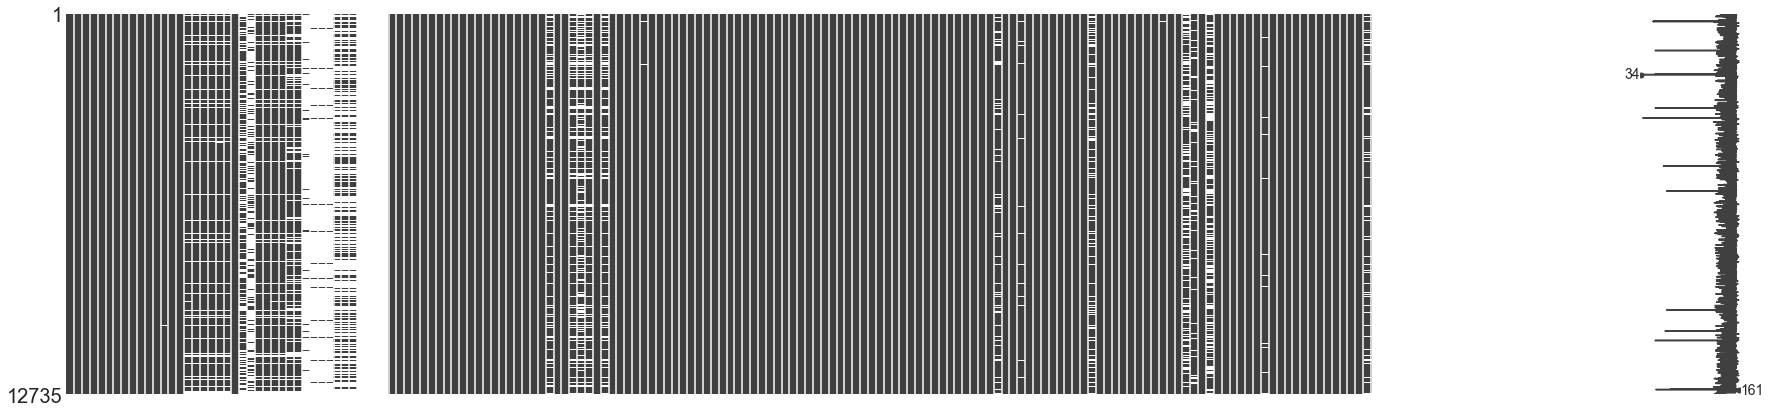

In [271]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_players_raw
msno.matrix(df_players_raw, figsize = (30, 7))

In [272]:
# Counts of missing values
null_value_stats = df_players_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

fbref_id                1
Pos                     1
Primary Pos             1
Position Grouped        3
age_when_joining     1027
                    ...  
Stp                 12735
Stp%                12735
#OPA                12735
#OPA/90             12735
AvgDist             12735
Length: 161, dtype: int64

The visualisation shows us very quickly that there are missing values in the dataset but as this data has been scraped from numerous sources and then matches with [record-linkage](https://recordlinkage.readthedocs.io/en/latest/about.html), this is to be expected.

---

<a id='section4'></a>

## <a id='#section4'>4. Data Engineering</a>
Before any Machine Learning or Data Analysis, the first step is to clean and wrangle the datasets to a form that meet our needs.

<a id='section4.1'></a>

### <a id='#section4.1'>4.1. Assign Raw DataFrame to a New DataFrame for Engineering</a>

In [273]:
# Assign Raw DataFrame to a New DataFrame for Engineering
df_players = df_players_raw

<a id='section4.2'></a>

### <a id='#section4.2'>4.2. Create 'Per 90' Stats</a>
Stats of interest in the original dataset which are required to be converted to 'per 90' (p90) stats for later analysis are:
- **Passes Completed** (`Cmp`)
- **Progressive Passes** (`Prog`)
- **Passes made while under pressure from opponent** (`Press`)
- **Number of times the player controlled the ball with their feet** (`Carries`)
- **Progressive Distance** (`PrgDist`)
- **Total distance, in yards, that completed passes have traveled in any direction** (`TotDist`)
- **Shot-Creating Actions** (`SCA`)

These stats of interest and why they are selected is discussed in greater detail, later in the notebook.

In [274]:
# Create 'p90' stats for stats of interest - change the code to a for loop, lazy solution
df_players['Cmp_p90'] = (df_players['Cmp'] / df_players['Min']) * 90
df_players['Prog_p90'] = (df_players['Prog'] / df_players['Min']) * 90
df_players['Press_p90'] = (df_players['Press'] / df_players['Min']) * 90
df_players['Carries_p90'] = (df_players['Carries'] / df_players['Min']) * 90
df_players['PrgDist_p90'] = (df_players['PrgDist'] / df_players['Min']) * 90
df_players['TotDist_p90'] = (df_players['TotDist'] / df_players['Min']) * 90
df_players['SCA_p90'] = (df_players['SCA'] / df_players['Min']) * 90

<a id='section4.3'></a>

### <a id='#section4.3'>4.3. Subset Data</a>
Filter for Defenders (as per the player's position of [FBref](https://fbref.com/)) that have played at least 10 matches (900 minutes) during the season.

In [20]:
# Filter for Defenders that have played at least 10 matches (900 minutes)
df_players_def = df_players[
                            (df_players['Primary Pos'] ==  'DF') &
                           #(df_players['TmPos'] == 'Centre-Back') &
                            (df_players['season'].isin(['2017/2018', '2018/2019', '2019/2020', '2020/2021'])) &
                            (df_players['Min'] >= 90 * 10)
                           ]

In [21]:
# Check the variance in the dataset before and after filtration
print('No. rows in Players DataFrame BEFORE filtration: {}'.format(len(df_players)))
print('No. rows AFTER filtration: {}'.format(len(df_players_def)))
print('-'*10+'\n')
print('Variance in rows before and after filtration: {}\n'.format(len(df_players_def) - len(df_players)))

No. rows in Players DataFrame BEFORE filtration: 12735
No. rows AFTER filtration: 2491
----------

Variance in rows before and after filtration: -10244



The dataset available for clustering is nearly 2,700 players over four seasons - which is a good size.

<a id='section4.4'></a>

### <a id='#section4.4'>4.4. Select Numerical and String Columns</a>
As part of the analysis, we require a mix of player performance stats, player bio, estimated market value, contractual status, and salary data.

The player performance metrics that are to go into the clustering are metrics for a ball-playing center back - a mix of defensive and passing/possession metrics. Irrelevant metrics for goalscoring and goalkeeper are not included as this will distrort the player profiles to be identified (commented out the full list).

The columns of interest from the dataset are the following...

In [22]:
# Define columns

## Str
cols_str = ['player_name_fbref',
            'season',
            'Squad',
           #'Team Country',
            'Comp',
            'Primary Pos',
            'Pos',
            'TmPos', 
           #'Position Grouped',
           #'outfielder_goalkeeper',
            'Age',
           #'age_when_joining',
            'dob',
            'height',
            'foot',         
           #'pob',
           #'cob',
            'Nationality Cleaned',
           #'citizenship',
           #'second_citizenship',          
            'market_value_gbp',
            'market_value_eur',
            'joined',
            'years_since_joining',
            'years_until_contract_expiry', 
            'contract_expires',
            'contract_option',
            'on_loan_from',
            'on_loan_from_country',
            'loan_contract_expiry',
            'weekly_gross_base_salary_gbp',
            'annual_gross_base_salary_gbp',
            'adj_current_gross_base_salary_gbp',
            'estimated_gross_total_gbp',
            'current_contract_status',
            'current_contract_expiration',
            'current_contract_length'
           ]
            
# Stats
cols_stats_select = [
                    #'MP',        # just using Minutes
                    #'Starts',     # just using Minutes     
                    #'90s',        # just using Minutes 
                    #'Gls',        # Goals
                     'Ast',        # Assists
                    #'G-PK',
                    #'PK',
                    #'PKatt',
                     'CrdY',
                     'CrdR',
                    #'G+A',
                    #'G+A-PK',
                    #'xG',
                    #'npxG',
                    #'xA',
                    #'npxG+xA',    # Removed for now
                    #'xG+xA',
                    #'Sh',
                    #'SoT',
                    #'SoT%',
                    #'Sh/90',
                    #'SoT/90',
                    #'G/Sh',
                    #'G/SoT',
                    #'Dist',
                    #'FK',
                    #'npxG/Sh',
                    #'G-xG',
                    #'np:G-xG',
                     'Cmp',
                     'Att',
                     'Cmp%',
                     'TotDist',
                     'PrgDist',
                     'A-xA',
                     'KP',
                    #'1/3',
                     'PPA',
                     'CrsPA',
                     'Prog',
                     'Live',
                    #'Dead',
                    #'TB',
                     'Press',
                     'Sw',
                    #'Crs',
                    #'CK',
                    #'In',
                    #'Out',
                    #'Str',
                     'Ground',
                     'Low',
                     'High',
                     'Left',
                     'Right',
                     'Head',
                     'TI',
                     'Other',
                     'Off',
                     'Int',
                     'Blocks',
                     'SCA',
                     'SCA90',
                     'PassLive',
                     'PassDead',
                     'Drib',
                     'Fld',
                     'Def',
                     'GCA',
                     'GCA90',
                     'Tkl',
                     'TklW',
                     'Def 3rd',
                     'Mid 3rd',
                     'Att 3rd',
                     'Tkl%',
                     'Past',
                     'Succ',
                     '%',
                     'ShSv',
                     'Pass',
                     'Tkl+Int',
                     'Clr',
                     'Err',
                     'Touches',
                     'Def Pen',
                     'Att Pen',
                     'Succ%',
                     '#Pl',
                    #'Megs',
                     'Carries',
                     'CPA',
                     'Mis',
                     'Dis',
                     'Targ',
                     'Rec',
                     'Rec%',
                    #'Mn/MP',    # just using Minutes
                    #'Min%',     # just using Minutes
                    #'Mn/Start', # just using Minutes
                    #'Compl',    # just using Minutes
                    #'Subs',     # just using Minutes
                    #'Mn/Sub',   # just using Minutes
                    #'unSub',    # just using Minutes
                    #'PPM',      # not including Team stats
                    #'onG',      # not including Team stats
                    #'onGA',     # not including Team stats
                    #'+/-',      # not including Team stats
                    #'+/-90',    # not including Team stats
                    #'On-Off',   # not including Team stats
                    #'onxG',     # not including Team stats
                    #'onxGA',    # not including Team stats
                    #'xG+/-',    # not including Team stats
                    #'xG+/-90',  # not including Team stats
                    #'2CrdY',    # only including yellow and red cards
                     'Fls',
                    #'PKwon',
                     'PKcon',
                     'OG',
                     'Recov',
                     'Won',
                     'Lost',
                     'Won%',
                    #'GA',
                    #'GA90',
                    #'Cmp_p90',        # Include newly created p90 value, removed for now
                    #'Prog_p90',       # Include newly created p90 value, removed for now
                    #'Press_p90',      # Include newly created p90 value, removed for now
                    #'Carries_p90',    # Include newly created p90 value, removed for now
                    #'PrgDist_p90',    # Include newly created p90 value, removed for now
                    #'TotDist_p90',    # Include newly created p90 value, removed for now
                    #'SCA_p90'
                    ]

##### DataFrame of String Values

In [23]:
# Create DataFrame of string values

## Select columns of interest
df_players_def_str = df_players_def[cols_str]

## Drop duplicate column (duplicate 'team', temporary solution, needs to be moved up)
df_players_def_str = df_players_def_str.loc[:, ~df_players_def_str.columns.duplicated()]

## Display DataFrame
df_players_def_str.head()

,player_name_fbref,season,Squad,Comp,Primary Pos,Pos,TmPos,Age,dob,height,foot,Nationality Cleaned,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length
3,Aaron Cresswell,2017/2018,West Ham,Premier League,DF,DF,Left-Back,27,15/12/1989,170.0,left,England,10800000.0,12000000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2671365.0,NaN,NaN,NaN,NaN
4,Aaron Cresswell,2018/2019,West Ham,Premier League,DF,DF,Left-Back,28,15/12/1989,170.0,left,England,9000000.0,10000000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2625727.0,NaN,NaN,NaN,NaN
5,Aaron Cresswell,2019/2020,West Ham,Premier League,DF,DF,Left-Back,29,15/12/1989,170.0,left,England,7200000.0,8000000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2600000.0,NaN,NaN,NaN,NaN
6,Aaron Cresswell,2020/2021,West Ham,Premier League,DF,DF,Left-Back,30,15/12/1989,170.0,left,England,5850000.0,6500000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2600000.0,NaN,NaN,NaN,NaN
31,Aaron Wan-Bissaka,2018/2019,Crystal Palace,Premier League,DF,DF,Right-Back,20,26/11/1997,183.0,right,England,9000000.0,10000000.0,01/07/2019,2.0,2.0,30/06/2024,club option 1 year,NaN,NaN,NaN,15000.0,780000.0,787718.0,NaN,NaN,NaN,NaN


In [24]:
# Display the shape of the DataFrame
df_players_def_str.shape

(2491, 29)

##### DataFrame of Stats Values

In [25]:
# Create DataFrame of numerical values

## Select columns of interest
df_players_def_stats = df_players_def[cols_stats_select]

## Drop duplicate column (duplicate 'team', temporary solution, needs to be moved up)
df_players_def_stats = df_players_def_stats.loc[:, ~df_players_def_stats.columns.duplicated()]

## Display DataFrame
df_players_def_stats.head()

,Ast,CrdY,CrdR,Cmp,Att,Cmp%,TotDist,PrgDist,A-xA,KP,PPA,CrsPA,Prog,Live,Press,Sw,Ground,Low,High,Left,Right,Head,TI,Other,Off,Int,Blocks,SCA,SCA90,PassLive,PassDead,Drib,Fld,Def,GCA,GCA90,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl%,Past,Succ,%,ShSv,Pass,Tkl+Int,Clr,Err,Touches,Def Pen,Att Pen,Succ%,#Pl,Carries,CPA,Mis,Dis,Targ,Rec,Rec%,Fls,PKcon,OG,Recov,Won,Lost,Won%,Cmp_p90,Prog_p90,Press_p90,Carries_p90,PrgDist_p90,TotDist_p90,SCA_p90
3,3,7,0,1224.0,1708.0,71.7,23519.0,10212.0,0.2,35.0,21.0,14.0,96.0,1343.0,222.0,83.0,893.0,293.0,522.0,1329.0,78.0,59.0,210.0,5.0,15.0,39.0,52.0,62.0,1.82,35.0,21.0,1.0,3.0,0.0,9.0,0.26,38.0,18.0,15.0,18.0,5.0,53.1,15.0,115.0,32.1,0.0,38.0,90.0,133.0,0.0,2050.0,125.0,17.0,33.3,7.0,1071.0,2.0,18.0,19.0,1171.0,1094.0,93.4,20,0.0,0.0,277.0,70.0,57.0,55.1,35.894428,2.815249,6.510264,31.407625,299.472141,689.706745,1.818182
4,1,1,0,842.0,1070.0,78.7,13627.0,5572.0,0.1,16.0,15.0,5.0,65.0,854.0,168.0,18.0,642.0,235.0,193.0,787.0,51.0,27.0,190.0,4.0,2.0,27.0,44.0,29.0,1.64,19.0,6.0,0.0,0.0,1.0,2.0,0.11,30.0,19.0,14.0,12.0,4.0,42.9,16.0,68.0,31.5,0.0,39.0,49.0,60.0,1.0,1266.0,78.0,36.0,63.6,7.0,723.0,8.0,11.0,13.0,797.0,715.0,89.7,2,0.0,0.0,169.0,22.0,14.0,61.1,47.690371,3.681561,9.515419,40.950283,315.594714,771.825047,1.642542
5,0,7,0,1241.0,1681.0,73.8,21630.0,10702.0,-1.8,23.0,22.0,15.0,123.0,1292.0,242.0,38.0,796.0,359.0,526.0,1201.0,81.0,41.0,325.0,1.0,6.0,19.0,77.0,46.0,1.52,33.0,6.0,2.0,4.0,0.0,2.0,0.07,48.0,29.0,25.0,18.0,5.0,40.7,35.0,118.0,33.2,0.0,54.0,63.0,92.0,2.0,1971.0,108.0,26.0,42.1,19.0,1076.0,3.0,9.0,13.0,1139.0,1047.0,91.9,16,0.0,0.0,295.0,51.0,34.0,60.0,40.957096,4.059406,7.986799,35.511551,353.201320,713.861386,1.518152
6,8,3,0,1541.0,2061.0,74.8,30884.0,14764.0,2.1,60.0,24.0,17.0,120.0,1617.0,158.0,84.0,1104.0,365.0,592.0,1607.0,118.0,49.0,259.0,4.0,23.0,48.0,66.0,96.0,2.73,48.0,41.0,1.0,2.0,0.0,14.0,0.40,31.0,13.0,15.0,14.0,2.0,41.2,20.0,67.0,29.1,0.0,34.0,67.0,98.0,0.0,2307.0,182.0,18.0,40.0,8.0,1266.0,3.0,7.0,9.0,1366.0,1318.0,96.5,13,0.0,0.0,307.0,38.0,30.0,55.9,43.750789,3.406940,4.485804,35.943218,419.167192,876.832808,2.725552
31,3,4,1,1147.0,1519.0,75.5,17052.0,8329.0,1.1,14.0,26.0,10.0,119.0,1177.0,221.0,12.0,845.0,343.0,331.0,106.0,1020.0,39.0,337.0,0.0,3.0,46.0,73.0,40.0,1.15,31.0,3.0,5.0,0.0,0.0,7.0,0.20,138.0,63.0,100.0,32.0,6.0,69.2,16.0,167.0,25.5,0.0,86.0,229.0,168.0,1.0,2112.0,179.0,39.0,73.0,78.0,1149.0,15.0,31.0,40.0,1031.0,928.0,90.0,23,1.0,0.0,292.0,31.0,34.0,47.7,32.938736,3.417358,6.346522,32.996171,239.186343,489.687301,1.148692


In [26]:
# Display the shape of the DataFrame
df_players_def_stats.shape

(2491, 76)

<a id='section4.5'></a>

### <a id='#section4.5'>4.5. Replace Nulls</a>
Replace all the NULL values with zero - this is required before any PCA or Clustering.

In [27]:
# Replace all the NULL values with zero.
df_players_def_stats.fillna(0, inplace=True)

<a id='section4.6'></a>

### <a id='#section4.6'>4.6. Standardise Data</a>
Standardise all the numerical values in the data to have a mean of ~0 and a variance of 1.

In [29]:
x = df_players_def_stats.values    # NumPy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

<a id='section4.7'></a>

### <a id='#section4.7'>4.7. Determine the Number of Clusters</a>
As part of the K-Means clustering.

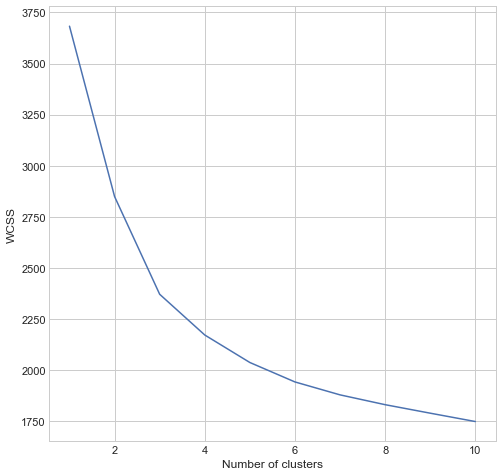

In [238]:
wcss = []
for i in range(1,11):
    model = KMeans(n_clusters = i, init = "k-means++", max_iter = 600, random_state=42)
    model.fit(x_scaled)
    wcss.append(model.inertia_)
plt.figure(figsize=(8, 8))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The plot shows that there is no particular elbow for this dataset, so I will elect to go with 5 clusters.

---

<a id='section5'></a>

## <a id='#section5'>5. Machine Learning</a>
The Machine Learning that takes place is in two steps:
1.    PCA
2.    K-Means Clustering

<a id='section5.1'></a>

### <a id='#section5.1'>5.1. PCA</a>
Using PCA, the dimensionality of the dataset is reduced from 77 dimensions into 2 for the plot.

2 dimensions is useful as the resulting arrays can be visualised, for this reason, 2 dimensions was selected.

<a id='section5.1.1.'></a>

#### <a id='#section5.1.1.'>5.1.1. Create a PCA Instance</a>

In [89]:
# Create a PCA Instance
pca = PCA(n_components = 2)    # 2D PCA for the plot

# Save components to a DataFrame
reduced = pd.DataFrame(pca.fit_transform(X_norm))

<a id='section5.1.2.'></a>

#### <a id='#section5.1.2.'>5.1.2. Plot the explained variances</a>

([<matplotlib.axis.XTick at 0x12b2df950>,
 [Text(0, 0, ''), Text(0, 0, '')])

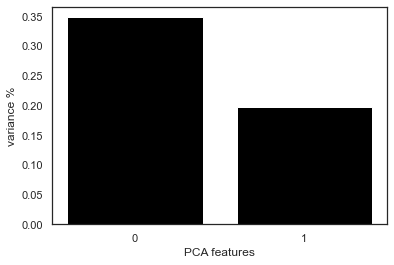

In [90]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

The figure shows that the first component explain the majority of the variance in our data. For this visualization use case, we will quickly plot just the first two. We do this to notice if there are any clear clusters.

<a id='section5.2'></a>

### <a id='#section5.2'>5.2. K-Means Clustering</a>
As previously discussed in the elbow plot, the K-Means will have 5 clusters.

In [32]:
 K-Means Clustering

## Specify the number of clusters
kmeans = KMeans(n_clusters=5)

## Fit the input data
kmeans = kmeans.fit(df_reduced)

## Get the cluster labels
labels = kmeans.predict(df_reduced)

## Centroid values
centroid = kmeans.cluster_centers_

## Cluster values
clusters = kmeans.labels_.tolist()

The next following commands creates a dataset of the PCA arrays, clusters, and player dataset, to be used for analysis.

In [33]:
# Convert string attributes to lists to be joined back onto the resulting DataFrame
# This is a bit of a lazy was to do this, just a temporary solution
names = df_players_def['player_name_fbref'].tolist()
season = df_players_def['season'].tolist()
minutes = df_players_def['Min'].tolist()
squad = df_players_def['Squad'].tolist()
comp = df_players_def['Comp'].tolist()
primary_pos = df_players_def['Primary Pos'].tolist()
pos = df_players_def['Pos'].tolist()
tm_pos = df_players_def['TmPos'].tolist()
age = df_players_def['Age'].tolist()
dob = df_players_def['dob'].tolist()
height = df_players_def['height'].tolist()
foot = df_players_def['foot'].tolist()
nationality = df_players_def['Nationality Cleaned'].tolist()
market_value_gbp = df_players_def['market_value_gbp'].tolist()
market_value_eur = df_players_def['market_value_eur'].tolist()
joined = df_players_def['joined'].tolist()
years_since_joining = df_players_def['years_since_joining'].tolist()
years_until_contract_expiry = df_players_def['years_until_contract_expiry'].tolist()
contract_expires = df_players_def['contract_expires'].tolist()
contract_option = df_players_def['contract_option'].tolist()
on_loan_from = df_players_def['on_loan_from'].tolist()
on_loan_from_country = df_players_def['on_loan_from_country'].tolist()
loan_contract_expiry = df_players_def['loan_contract_expiry'].tolist()
weekly_gross_base_salary_gbp = df_players_def['weekly_gross_base_salary_gbp'].tolist()
annual_gross_base_salary_gbp = df_players_def['annual_gross_base_salary_gbp'].tolist()
adj_current_gross_base_salary_gbp = df_players_def['adj_current_gross_base_salary_gbp'].tolist()
estimated_gross_total_gbp = df_players_def['estimated_gross_total_gbp'].tolist()
current_contract_status = df_players_def['current_contract_status'].tolist()
current_contract_expiration = df_players_def['current_contract_expiration'].tolist()
current_contract_length = df_players_def['current_contract_length'].tolist()

In [34]:
# Create new columns of the DataFrame from each of the lists of string values
df_reduced['cluster'] = clusters
df_reduced['name'] = names
df_reduced['season'] = season
df_reduced['minutes'] = minutes
df_reduced['squad'] = squad
df_reduced['league'] = comp
df_reduced['primary_position'] = primary_pos
df_reduced['positions'] = pos
df_reduced['tm_position'] = tm_pos
df_reduced['age'] = age
df_reduced['dob'] = dob
df_reduced['height'] = height
df_reduced['foot'] = foot
df_reduced['nationality'] = nationality
df_reduced['market_value_gbp'] = market_value_gbp
df_reduced['market_value_eur'] = market_value_eur
df_reduced['joined'] = joined
df_reduced['years_since_joining'] = years_since_joining
df_reduced['years_until_contract_expiry'] = years_until_contract_expiry
df_reduced['contract_expires'] = contract_expires
df_reduced['contract_option'] = contract_option
df_reduced['on_loan_from'] = on_loan_from
df_reduced['on_loan_from_country'] = on_loan_from_country
df_reduced['loan_contract_expiry'] = loan_contract_expiry
df_reduced['weekly_gross_base_salary_gbp'] = weekly_gross_base_salary_gbp 
df_reduced['annual_gross_base_salary_gbp'] = annual_gross_base_salary_gbp
df_reduced['adj_current_gross_base_salary_gbp'] = adj_current_gross_base_salary_gbp
df_reduced['estimated_gross_total_gbp'] = estimated_gross_total_gbp
df_reduced['current_contract_status'] = current_contract_status
df_reduced['current_contract_expiration'] = current_contract_expiration
df_reduced['current_contract_length'] = current_contract_length

In [35]:
# Create a DataFrame of string columns and resulting PCA arrays
df_reduced.columns = ['x',
                      'y',
                      'cluster',
                      'name',
                      'season',
                      'minutes',
                      'squad',
                      'league',
                      'primary_position',
                      'positions',
                      'tm_position',
                      'age',
                      'dob',
                      'height',
                      'foot',
                      'nationality',
                      'market_value_gbp',
                      'market_value_eur',
                      'joined',
                      'years_since_joining',
                      'years_until_contract_expiry',
                      'contract_expires',
                      'contract_option',
                      'on_loan_from',
                      'on_loan_from_country',
                      'loan_contract_expiry',
                      'weekly_gross_base_salary_gbp',
                      'annual_gross_base_salary_gbp',
                      'adj_current_gross_base_salary_gbp',
                      'estimated_gross_total_gbp',
                      'current_contract_status',
                      'current_contract_expiration',
                      'current_contract_length'              
                     ]

In [36]:
# Display the shape of the new DataFrame
df_reduced.shape

(2491, 33)

In [37]:
# Display the DataFrame
df_reduced.head()

,x,y,cluster,name,season,minutes,squad,league,primary_position,positions,tm_position,age,dob,height,foot,nationality,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length
0,0.832523,-0.263972,1,Aaron Cresswell,2017/2018,3069,West Ham,Premier League,DF,DF,Left-Back,27,15/12/1989,170.0,left,England,10800000.0,12000000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2671365.0,NaN,NaN,NaN,NaN
1,-0.053447,-0.442615,3,Aaron Cresswell,2018/2019,1589,West Ham,Premier League,DF,DF,Left-Back,28,15/12/1989,170.0,left,England,9000000.0,10000000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2625727.0,NaN,NaN,NaN,NaN
2,0.786940,-0.307606,1,Aaron Cresswell,2019/2020,2727,West Ham,Premier League,DF,DF,Left-Back,29,15/12/1989,170.0,left,England,7200000.0,8000000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2600000.0,NaN,NaN,NaN,NaN
3,1.253374,-0.416832,1,Aaron Cresswell,2020/2021,3170,West Ham,Premier League,DF,DF,Left-Back,30,15/12/1989,170.0,left,England,5850000.0,6500000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2600000.0,NaN,NaN,NaN,NaN
4,1.246350,-0.338362,1,Aaron Wan-Bissaka,2018/2019,3134,Crystal Palace,Premier League,DF,DF,Right-Back,20,26/11/1997,183.0,right,England,9000000.0,10000000.0,01/07/2019,2.0,2.0,30/06/2024,club option 1 year,NaN,NaN,NaN,15000.0,780000.0,787718.0,NaN,NaN,NaN,NaN


---

<a id='section6'></a>

## <a id='#section6'>6. Data Visualisation</a>
The cluster analysis is visualised in [matplotlib](https://matplotlib.org/).

/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


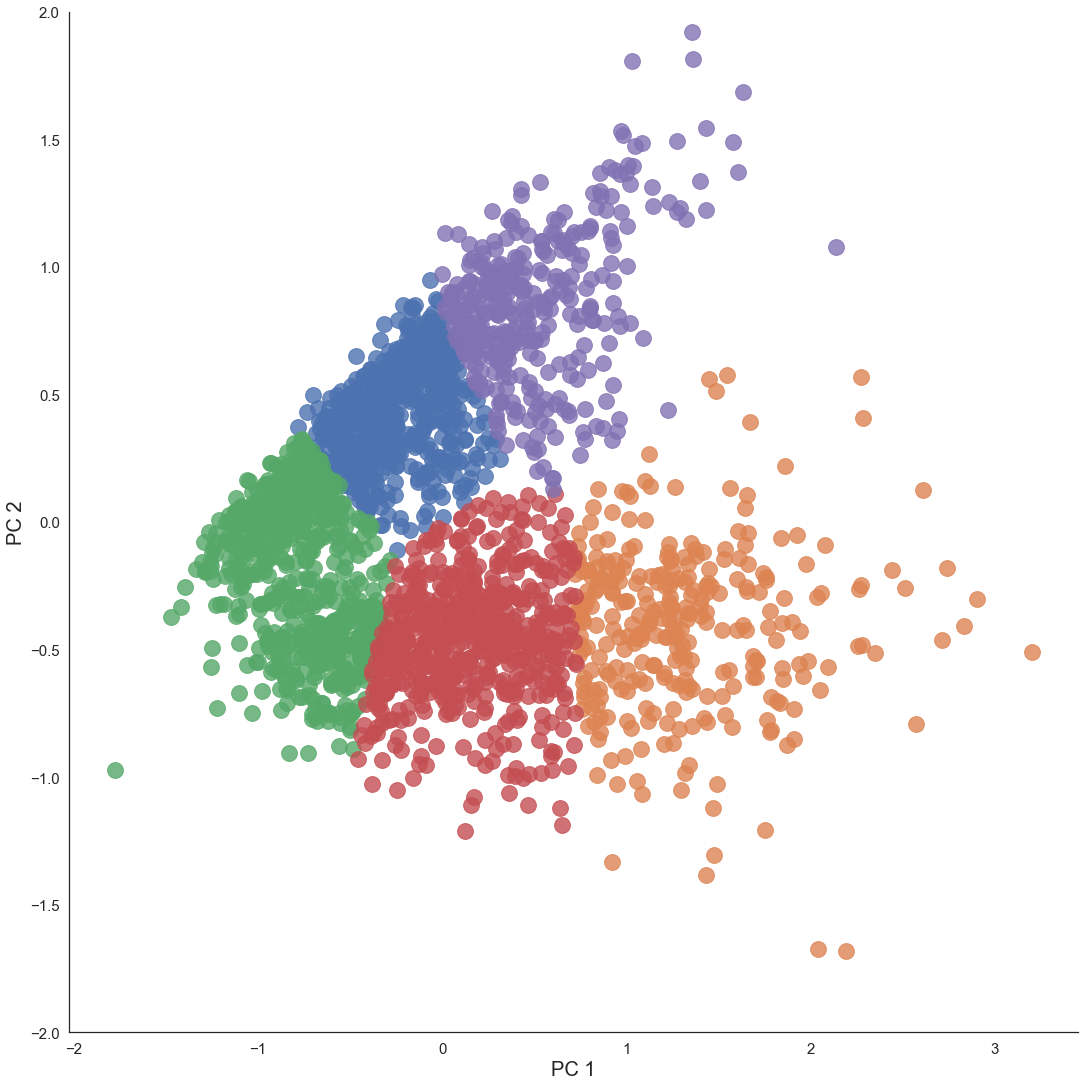

In [38]:
# Visualise the clustering
sns.set(style="white")
ax = sns.lmplot(x="x", y="y", hue='cluster', data = df_reduced, legend=False,
fit_reg=False, size = 15, scatter_kws={"s": 250})
texts = []
#for x, y, s in zip(df_reduced.x, df_reduced.y, df_reduced.name):
    #texts.append(plt.text(x, y, s))
ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)
plt.show()

In [39]:
# Display the counts of the clusters
df_reduced['cluster'].value_counts()

2    678
3    600
0    556
4    354
1    303
Name: cluster, dtype: int64

The results produces 5 distinct clusters, as previously stated, the most populus being cluster 2 with 678 players, followed by cluster 3 (600), 0 (556), 4 (354) and 1 (303).

The next step is to identify the cluster(s) that Gerard Piqué is located for the four seasons of data that we have for him, from 17/18 to 20/21.

In [41]:
# Subset the reduced DataFrame for Piqué data points
df_reduced_pique = df_reduced[df_reduced['name'].str.contains('Gerard Piqu')]

# Display the DataFrame
df_reduced_pique

,x,y,cluster,name,season,minutes,squad,league,primary_position,positions,tm_position,age,dob,height,foot,nationality,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length
829,0.329662,0.980776,4,Gerard PiquÃ©,2017/2018,2631,Barcelona,La Liga,DF,DF,Centre-Back,30,02/02/1987,194.0,right,Spain,36000000.0,40000000.0,01/07/2008,13.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,218534.0,11363788.0,11406357.0,NaN,NaN,NaN,NaN
830,1.010337,1.401113,4,Gerard PiquÃ©,2018/2019,3150,Barcelona,La Liga,DF,DF,Centre-Back,31,02/02/1987,194.0,right,Spain,36000000.0,40000000.0,01/07/2008,13.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,220629.0,11472752.0,11435733.0,NaN,NaN,NaN,NaN
831,1.030607,1.804965,4,Gerard PiquÃ©,2019/2020,3092,Barcelona,La Liga,DF,DF,Centre-Back,32,02/02/1987,194.0,right,Spain,22500000.0,25000000.0,01/07/2008,13.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,432946.0,22513250.0,22513250.0,NaN,NaN,NaN,NaN
832,-0.466811,0.650823,0,Gerard PiquÃ©,2020/2021,1481,Barcelona,La Liga,DF,DF,Centre-Back,33,02/02/1987,194.0,right,Spain,13500000.0,15000000.0,01/07/2008,13.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,22166.0,1152678.0,1152678.0,NaN,NaN,NaN,NaN


From the results, we can see that Piqué is found in cluster 4 for the the first 0 seasons and then in cluster 0 for the 20/21 season - indicating that the numbers produced by Piqué in his most recent completed season, for whatever reason.

Next let's annotate the visualisation to see where the points for Piqué can be found in the visualisation.

In [42]:
# Create variables of the x, y coordinates of the Piqué data points, to be plotted on the visualisation
pique_x_1718 = float(df_reduced['x'][(df_reduced.season == '2017/2018') & (df_reduced['name'].str.contains('Gerard Piqu'))])
pique_y_1718 = float(df_reduced['y'][(df_reduced.season == '2017/2018') & (df_reduced['name'].str.contains('Gerard Piqu'))])
pique_x_1819 = float(df_reduced['x'][(df_reduced.season == '2018/2019') & (df_reduced['name'].str.contains('Gerard Piqu'))])
pique_y_1819 = float(df_reduced['y'][(df_reduced.season == '2018/2019') & (df_reduced['name'].str.contains('Gerard Piqu'))])
pique_x_1920 = float(df_reduced['x'][(df_reduced.season == '2019/2020') & (df_reduced['name'].str.contains('Gerard Piqu'))])
pique_y_1920 = float(df_reduced['y'][(df_reduced.season == '2019/2020') & (df_reduced['name'].str.contains('Gerard Piqu'))])
pique_x_2021 = float(df_reduced['x'][(df_reduced.season == '2020/2021') & (df_reduced['name'].str.contains('Gerard Piqu'))])
pique_y_2021 = float(df_reduced['y'][(df_reduced.season == '2020/2021') & (df_reduced['name'].str.contains('Gerard Piqu'))])

# Find the centroid (midpoint) of the 17/18-19/20 Piqué data points triangle (ignoring 20/21 performance)
pique_x_centroid = (pique_x_1718 + pique_x_1819 + pique_x_1920) / 3
pique_y_centroid = (pique_y_1718 + pique_y_1819 + pique_y_1920) / 3

/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


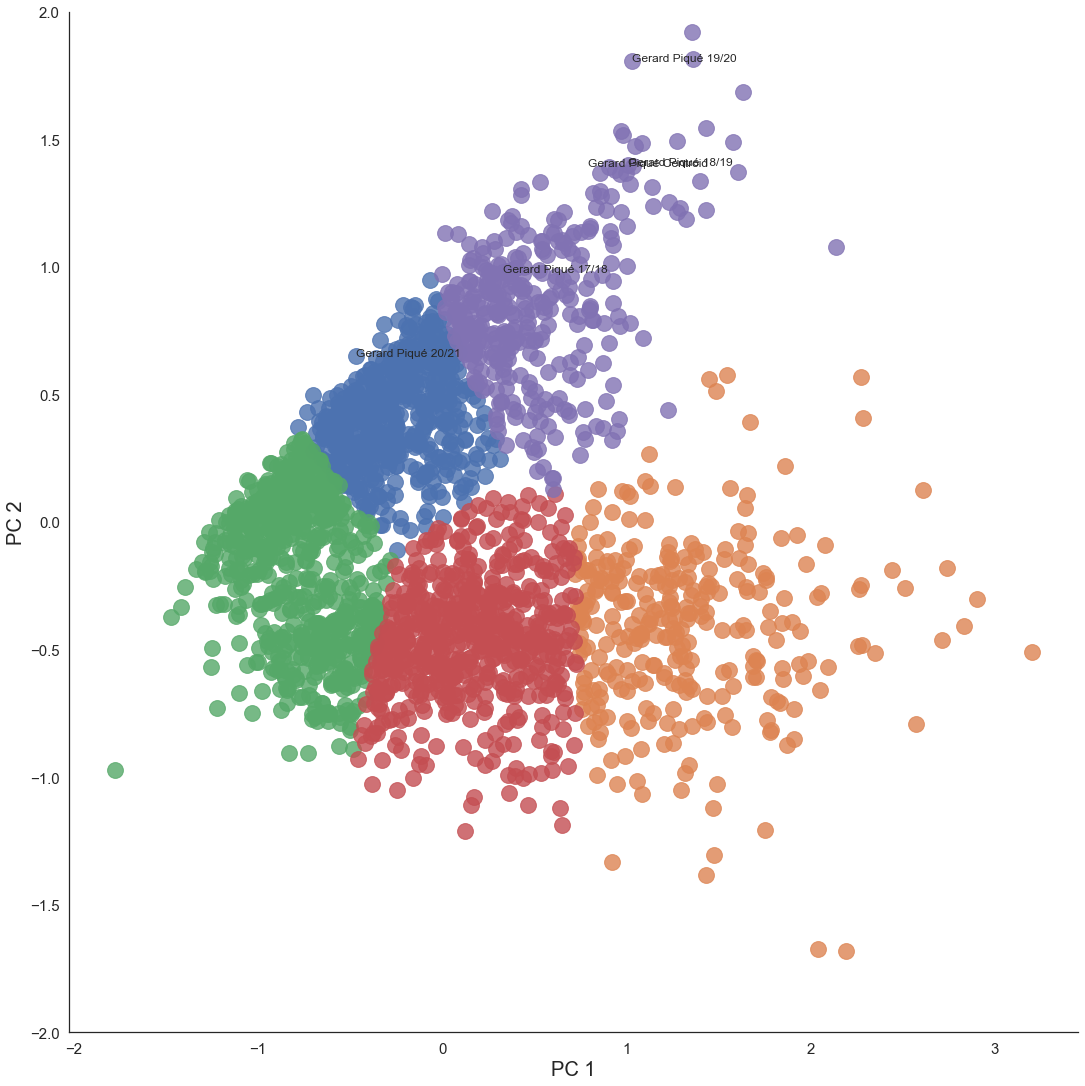

In [242]:
# Visualise the clustering, now including Piqué data points
sns.set(style="white")
ax = sns.lmplot(x="x", y="y", hue='cluster', data = df_reduced, legend=False,
fit_reg=False, size = 15, scatter_kws={"s": 250})
texts = []
plt.annotate("Gerard Piqué 17/18", (pique_x_1718, pique_y_1718))
plt.annotate("Gerard Piqué 18/19", (pique_x_1819, pique_y_1819))
plt.annotate("Gerard Piqué 19/20", (pique_x_1920, pique_y_1920))
plt.annotate("Gerard Piqué 20/21", (pique_x_2021, pique_y_2021))
plt.annotate("Gerard Piqué Centroid", (pique_x_centroid, pique_y_centroid))
ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)
plt.show()

From the visualisation we can now see the points for Piqué in the purple, cluster 4 for the 17/18-19/20 seasons, as well as the point for cluster 0 (blue) for the 20/21 season.

The visualisation also plots the centroid of the triangle of points for the points in cluster 4, which lies very close to the point for Piqué's 18/19 performance.

The next step is to determine the distance of each player to each of the four points for Piqué and the centroid for cluster 4. From this, we can then identify players that lies close to Piqué in the cluster and use this as a point to start identifying similar players.

In [44]:
# Determine the distance of each data point from each of the four Piqué data points
df_reduced['dist_pique_1718'] = np.sqrt( (pique_x_1718 - df_reduced['x'])**2 + (pique_y_1718 - df_reduced['y'])**2)
df_reduced['dist_pique_1819'] = np.sqrt( (pique_x_1819 - df_reduced['x'])**2 + (pique_y_1819 - df_reduced['y'])**2)
df_reduced['dist_pique_1920'] = np.sqrt( (pique_x_1920 - df_reduced['x'])**2 + (pique_y_1920 - df_reduced['y'])**2)
df_reduced['dist_pique_2021'] = np.sqrt( (pique_x_2021 - df_reduced['x'])**2 + (pique_y_2021 - df_reduced['y'])**2)

# Determine the distance of each data point from the 17/18-19/20 Piqué data points centroid
df_reduced['dist_pique_centroid'] = np.sqrt( (pique_x_centroid - df_reduced['x'])**2 + (pique_y_centroid - df_reduced['y'])**2)

In [45]:
# Display the DataFrame
df_reduced.head()

,x,y,cluster,name,season,minutes,squad,league,primary_position,positions,tm_position,age,dob,height,foot,nationality,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length,dist_pique_1718,dist_pique_1819,dist_pique_1920,dist_pique_2021,dist_pique_centroid
0,0.832523,-0.263972,1,Aaron Cresswell,2017/2018,3069,West Ham,Premier League,DF,DF,Left-Back,27,15/12/1989,170.0,left,England,10800000.0,12000000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2671365.0,NaN,NaN,NaN,NaN,1.342485,1.674552,2.078397,1.589062,1.660129
1,-0.053447,-0.442615,3,Aaron Cresswell,2018/2019,1589,West Ham,Premier League,DF,DF,Left-Back,28,15/12/1989,170.0,left,England,9000000.0,10000000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2625727.0,NaN,NaN,NaN,NaN,1.474048,2.128607,2.495353,1.168964,2.022584
2,0.786940,-0.307606,1,Aaron Cresswell,2019/2020,2727,West Ham,Premier League,DF,DF,Left-Back,29,15/12/1989,170.0,left,England,7200000.0,8000000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2600000.0,NaN,NaN,NaN,NaN,1.367126,1.723260,2.126577,1.578125,1.703227
3,1.253374,-0.416832,1,Aaron Cresswell,2020/2021,3170,West Ham,Premier League,DF,DF,Left-Back,30,15/12/1989,170.0,left,England,5850000.0,6500000.0,03/07/2014,7.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,50000.0,2600000.0,2600000.0,NaN,NaN,NaN,NaN,1.675277,1.834118,2.232936,2.024579,1.870696
4,1.246350,-0.338362,1,Aaron Wan-Bissaka,2018/2019,3134,Crystal Palace,Premier League,DF,DF,Right-Back,20,26/11/1997,183.0,right,England,9000000.0,10000000.0,01/07/2019,2.0,2.0,30/06/2024,club option 1 year,NaN,NaN,NaN,15000.0,780000.0,787718.0,NaN,NaN,NaN,NaN,1.606376,1.755413,2.154158,1.978233,1.792975


---

<a id='section7'></a>

## <a id='#section7'>7. Exploratory Data Analysis</a>
The filtration of the players is done in the folowing steps:
*    Closest Performing Players During the Full Four Seasons
*    Closest Performing Players for the 20/21 Season
*    Closest Performing Young Players (U23)
*    Closest Performing Young Players (U23) within Budget
*    Closest Performing Young Players (U23) within Budget with an Expiring Contract

<a id='section7.1'></a>

### <a id='#section7.1'>7.1. Closest Performing Players During the Full Four Seasons</a>
The data is first filtered for players in the same cluster as Pique.

In [244]:
# Define Piqué cluster number
pique_cluster = int(df_reduced['cluster'][(df_reduced.season == '2018/2019') & (df_reduced['name'].str.contains('Gerard Piqu'))])
pique_cluster

4

In [66]:
# Filter the DataFrame by players in the same cluster as Piqué
df_pique_cluster = df_reduced[(df_reduced['cluster'] == pique_cluster)]

# Display the DataFrame
df_pique_cluster.sort_values(by=['dist_pique_centroid'], ascending=True).head(10)

,x,y,cluster,name,season,minutes,squad,league,primary_position,positions,tm_position,age,dob,height,foot,nationality,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length,dist_pique_1718,dist_pique_1819,dist_pique_1920,dist_pique_2021,dist_pique_centroid
2471,0.855557,1.366290,4,ÃaÄlar SÃ¶yÃ¼ncÃ¼,2019/2020,3036,Leicester City,Premier League,DF,DF,Centre-Back,23,NaN,NaN,NaN,Turkey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.652062,0.158649,0.472312,1.503512,0.071634
1146,0.818875,1.291376,4,JosÃ© Fonte,2020/2021,3185,Lille,Ligue 1,DF,DF,Centre-Back,36,22/12/1983,191.0,right,Portugal,1350000.0,1500000.0,15/07/2018,3.0,0.0,30/06/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.579484,0.220680,0.555521,1.436418,0.108114
499,0.854276,1.299286,4,Dante,2018/2019,3226,Nice,Ligue 1,DF,DF,Centre-Back,34,18/10/1983,189.0,left,Brazil,1350000.0,1500000.0,23/08/2016,5.0,0.0,30/06/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.613733,0.186342,0.535540,1.471657,0.115695
2088,0.907949,1.389834,4,RÃºben Dias,2020/2021,2843,Manchester City,Premier League,DF,DF,Centre-Back,23,14/05/1997,187.0,right,Portugal,54000000.0,60000000.0,29/09/2020,0.0,4.0,30/06/2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.708339,0.103007,0.432872,1.560802,0.117889
1092,0.860728,1.277031,4,Jonathan Tah,2018/2019,2937,Leverkusen,Bundeliga,DF,DF,Centre-Back,22,11/02/1996,195.0,right,Germany,28800000.0,32000000.0,16/07/2015,6.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,51780.0,2692584.0,2706227.0,NaN,NaN,NaN,NaN,0.608109,0.194368,0.554593,1.467820,0.137974
1502,0.937405,1.378660,4,Marcelo,2018/2019,2878,Lyon,Ligue 1,DF,DF,Centre-Back,31,20/05/1987,191.0,right,Brazil,8100000.0,9000000.0,01/01/2007,14.0,0.0,30/06/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.726403,0.076310,0.436374,1.581634,0.148176
272,0.837503,1.233137,4,BenoÃ®t Badiashile,2020/2021,2870,Monaco,Ligue 1,DF,DF,Centre-Back,19,26/03/2001,194.0,left,France,22500000.0,25000000.0,01/07/2018,3.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.567088,0.241013,0.603552,1.428399,0.169226
2157,0.914907,1.279023,4,Sergio Ramos,2019/2020,3013,Real Madrid,La Liga,DF,DF,Centre-Back,33,30/03/1986,184.0,right,Spain,16200000.0,18000000.0,08/07/2021,0.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,422209.0,21954921.0,21954921.0,NaN,NaN,NaN,NaN,0.656858,0.154960,0.538518,1.517821,0.170722
2243,0.965303,1.362200,4,Sven Botman,2020/2021,3309,Lille,Ligue 1,DF,DF,Centre-Back,20,12/01/2000,195.0,left,Netherlands,9000000.0,10000000.0,31/07/2020,1.0,3.0,30/06/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.741298,0.059517,0.447555,1.599064,0.178261
1366,0.887876,1.223339,4,Lewis Dunk,2019/2020,3230,Brighton,Premier League,DF,DF,Centre-Back,27,21/11/1991,192.0,right,England,18000000.0,20000000.0,01/07/2010,11.0,3.0,30/06/2025,NaN,NaN,NaN,NaN,45000.0,2340000.0,2340000.0,NaN,NaN,NaN,NaN,0.608637,0.215871,0.598883,1.470697,0.198041


In [67]:
# Display the shape of the DataFrame
df_pique_cluster.shape

(354, 38)

The data has been filtered to identify the players players most similar in the data over the last 4 seasons, with 354 players in the same cluster as Piqué. However, as this is a recruitment exercise for the present, it's important to look at recent player performance.

The next filters the data for just the most recent full season, 2020/2021, for the players with the 'Piqué-esk' performances.

<a id='section7.2'></a>

### <a id='#section7.2'>7.2. Closest Performing Players for the 20/21 Season

In [68]:
# Filter the DataFrame by players in the same cluster as Piqué and for the 20/21 season
df_2021 = df_reduced[(df_reduced['cluster'] == pique_cluster) &
                     (df_reduced['season'] == '2020/2021') 
                    ]

# Display the DataFrame
df_2021.sort_values(by=['dist_pique_centroid'], ascending=True).head(20)

,x,y,cluster,name,season,minutes,squad,league,primary_position,positions,tm_position,age,dob,height,foot,nationality,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length,dist_pique_1718,dist_pique_1819,dist_pique_1920,dist_pique_2021,dist_pique_centroid
1146,0.818875,1.291376,4,JosÃ© Fonte,2020/2021,3185,Lille,Ligue 1,DF,DF,Centre-Back,36,22/12/1983,191.0,right,Portugal,1350000.0,1500000.0,15/07/2018,3.0,0.0,30/06/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.579484,0.220680,0.555521,1.436418,0.108114
2088,0.907949,1.389834,4,RÃºben Dias,2020/2021,2843,Manchester City,Premier League,DF,DF,Centre-Back,23,14/05/1997,187.0,right,Portugal,54000000.0,60000000.0,29/09/2020,0.0,4.0,30/06/2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.708339,0.103007,0.432872,1.560802,0.117889
272,0.837503,1.233137,4,BenoÃ®t Badiashile,2020/2021,2870,Monaco,Ligue 1,DF,DF,Centre-Back,19,26/03/2001,194.0,left,France,22500000.0,25000000.0,01/07/2018,3.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.567088,0.241013,0.603552,1.428399,0.169226
2243,0.965303,1.362200,4,Sven Botman,2020/2021,3309,Lille,Ligue 1,DF,DF,Centre-Back,20,12/01/2000,195.0,left,Netherlands,9000000.0,10000000.0,31/07/2020,1.0,3.0,30/06/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.741298,0.059517,0.447555,1.599064,0.178261
1386,0.662135,1.213292,4,LoÃ¯c Bade,2020/2021,2610,Lens,Ligue 1,DF,DF,Centre-Back,20,NaN,NaN,NaN,France,24300000.0,27000000.0,11/04/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405711,0.395627,0.697028,1.261305,0.222809
1757,0.980592,1.515763,4,Nayef Aguerd,2020/2021,3147,Rennes,Ligue 1,DF,DF,Centre-Back,24,30/03/1996,190.0,left,Morocco,7200000.0,8000000.0,14/08/2020,1.0,3.0,30/06/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.842567,0.118446,0.293494,1.686148,0.225129
894,0.803516,1.151745,4,Harry Maguire,2020/2021,3047,Manchester Utd,Premier League,DF,DF,Centre-Back,27,05/03/1993,194.0,right,England,36000000.0,40000000.0,05/08/2019,2.0,3.0,30/06/2025,Option for a further year,NaN,NaN,NaN,190000.0,9880000.0,9880000.0,NaN,NaN,NaN,NaN,0.503753,0.323974,0.691568,1.365523,0.244237
1187,0.971473,1.215705,4,Jules KoundÃ©,2020/2021,2975,Sevilla,La Liga,DF,DF,Centre-Back,21,13/02/1998,181.0,left,France,32400000.0,36000000.0,01/07/2017,4.0,0.0,30/06/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.683456,0.189437,0.592220,1.545235,0.255397
1367,0.531643,1.332937,4,Lewis Dunk,2020/2021,2931,Brighton,Premier League,DF,DF,Centre-Back,28,21/11/1991,192.0,right,England,24300000.0,27000000.0,01/07/2010,11.0,3.0,30/06/2025,NaN,NaN,NaN,NaN,45000.0,2340000.0,2340000.0,NaN,NaN,NaN,NaN,0.405972,0.483524,0.686859,1.209210,0.266048
2037,0.627609,1.183240,4,Robin Knoche,2020/2021,3042,Union Berlin,Bundeliga,DF,DF,Centre-Back,28,22/05/1992,190.0,right,Germany,5850000.0,6500000.0,04/08/2020,1.0,NaN,NaN,NaN,NaN,NaN,NaN,50000.0,2600000.0,2600000.0,NaN,NaN,NaN,NaN,0.360227,0.440396,0.740911,1.217055,0.267471


In [69]:
# Display the shape of the DataFrame
df_2021.shape

(118, 38)

The data has been filtered for players in the same cluster as Piqué for just the 20/21 season, leaving 118 players.

The players in 20/21 with the most Piqué-esk performances include: José Fonte, Rúben Dias (Premier League Player of the Season), Harry Maguire (Manchester United and England Captain), Jules Kounde (linked with Chelsea [[link](https://www.si.com/soccer/chelsea/transfer-news/report-chelsea-still-interested-in-sevilla-defender-jules-kounde)]), Dayot Upamecano (recently signed with Bayern Munich [[link](https://www.google.com/search?q=upamecano+bayern+transfer&rlz=1C5CHFA_enGB880GB880&sxsrf=AOaemvKUdiEHOCoB83mql-B6oQToTGXBIA%3A1636059319985&ei=t0iEYYOQO6fX1sQPh6qp6AI&oq=upamecano+bayern+transfer&gs_lcp=Cgdnd3Mtd2l6EAMyBQgAEIAEMgYIABAWEB4yBggAEBYQHjIGCAAQFhAeMgYIABAWEB46BwgjELADECc6BwgAEEcQsAM6CgguEMgDELADEEM6BAgAEEM6BQguEIAEOggILhCABBCTAkoFCDgSATFKBAhBGABQfliYF2DwF2gCcAJ4AIABtQGIAYUMkgEEMTMuM5gBAKABAcgBD8ABAQ&sclient=gws-wiz&ved=0ahUKEwjDx-T0y__zAhWnq5UCHQdVCi0Q4dUDCA8&uact=5)], Jan Bednarek, Mats Hummels, Manuel Akanji, and Clement Lenglet (Barcelona team mate).

This is a good sign as many of these in the list are high-value, reputable players, playing at some of the best clubs in the world, with similar ball-playing attributes to Piqué.

The next step is to look as some of the players that are producing Piqué numbers, but fit the brief of players under the age of 23.

<a id='section7.3'></a>

### <a id='#section7.3'>7.3. Closest Performing Young Players (U23)
As per the email brief, this recruitment task is looking to identify young players of 23 years or under. The next step is to filter the data for these players.

In [70]:
# Filter the DataFrame by players in the same cluster as Piqué, in the 20/21 season and under 23 years of age
df_2021_u23 = df_reduced[(df_reduced['cluster'] == pique_cluster) &
                         (df_reduced['season'] == '2020/2021') &
                         (df_reduced['age'] <= 23)
                        ]

# Display the DataFrame
df_2021_u23.sort_values(by=['dist_pique_centroid'], ascending=True).head(20)

,x,y,cluster,name,season,minutes,squad,league,primary_position,positions,tm_position,age,dob,height,foot,nationality,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length,dist_pique_1718,dist_pique_1819,dist_pique_1920,dist_pique_2021,dist_pique_centroid
2088,0.907949,1.389834,4,RÃºben Dias,2020/2021,2843,Manchester City,Premier League,DF,DF,Centre-Back,23,14/05/1997,187.0,right,Portugal,54000000.0,60000000.0,29/09/2020,0.0,4.0,30/06/2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.708339,0.103007,0.432872,1.560802,0.117889
272,0.837503,1.233137,4,BenoÃ®t Badiashile,2020/2021,2870,Monaco,Ligue 1,DF,DF,Centre-Back,19,26/03/2001,194.0,left,France,22500000.0,25000000.0,01/07/2018,3.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.567088,0.241013,0.603552,1.428399,0.169226
2243,0.965303,1.362200,4,Sven Botman,2020/2021,3309,Lille,Ligue 1,DF,DF,Centre-Back,20,12/01/2000,195.0,left,Netherlands,9000000.0,10000000.0,31/07/2020,1.0,3.0,30/06/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.741298,0.059517,0.447555,1.599064,0.178261
1386,0.662135,1.213292,4,LoÃ¯c Bade,2020/2021,2610,Lens,Ligue 1,DF,DF,Centre-Back,20,NaN,NaN,NaN,France,24300000.0,27000000.0,11/04/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405711,0.395627,0.697028,1.261305,0.222809
1187,0.971473,1.215705,4,Jules KoundÃ©,2020/2021,2975,Sevilla,La Liga,DF,DF,Centre-Back,21,13/02/1998,181.0,left,France,32400000.0,36000000.0,01/07/2017,4.0,0.0,30/06/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.683456,0.189437,0.592220,1.545235,0.255397
549,0.915213,1.115044,4,Dayot Upamecano,2020/2021,2330,RB Leipzig,Bundeliga,DF,DF,Centre-Back,21,27/10/1998,186.0,right,France,54000000.0,60000000.0,05/07/2021,0.0,4.0,30/06/2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600747,0.301469,0.699504,1.457906,0.307163
1891,0.442583,0.999933,4,Pau Torres,2020/2021,2970,Villarreal,La Liga,DF,DF,Centre-Back,23,16/01/1997,191.0,left,Spain,36000000.0,40000000.0,01/07/2018,3.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.114534,0.695190,0.996919,0.974102,0.526693
1653,0.580490,0.878958,4,Maxence Lacroix,2020/2021,2590,Wolfsburg,Bundeliga,DF,DF,Centre-Back,20,15/02/2000,174.0,right,France,10800000.0,12000000.0,14/12/2018,2.0,1.0,30/06/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.270705,0.676323,1.029608,1.071860,0.557599
2314,0.278729,1.102678,4,Tosin Adarabioyo,2020/2021,2953,Fulham,Premier League,DF,DF,Centre-Back,22,24/09/1997,196.0,right,England,4500000.0,5000000.0,05/10/2020,0.0,1.0,30/06/2023,club option 1 year,NaN,NaN,NaN,40500.0,2106000.0,2106000.0,NaN,NaN,NaN,NaN,0.132114,0.790135,1.028848,0.871781,0.589422
1767,0.352150,0.984733,4,Nico Elvedi,2020/2021,2536,M'Gladbach,Bundeliga,DF,DF,Centre-Back,23,30/09/1996,189.0,right,Switzerland,27000000.0,30000000.0,01/07/2015,6.0,2.0,30/06/2024,performance option,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022833,0.778834,1.064464,0.884416,0.600597


In [71]:
# Display the shape of the DataFrame
df_2021_u23.shape

(30, 38)

The shortlist of players is closer to what we need, filtering out older players such as 37 year old José Fonte. This leaves 30 remaining players, however, many of these young players are outside of the budget of Parma Calcio.

As per TransferMarkt, the average estimated value of a defender for Parma Calcio for the 21/22 season is €1.68M (max €4.0M).

As per and Capology, the average player salary per week for the 21/22 season is €10.8k. During the 20/21 season, when Parma Calcio played in Serie A, the max salary for a defender was  €71.k by Andrea Conti, followed by Mattia Bani with €25.0k. This average weekly salary was halved from €18.4k per player for the 20/21 season, to €10.8k per player for the 21/22 season, following the clubs relegation from Serie A to Serie B.

Subsequently, I would estimate that a reasonable budget for potential central defenders for Parma would be a maximum estimated value of €5.0M (to give or take a million) and maximum weekly salary of €12.5k, as per TransferMarkt and Capology respectively.

The next step is to filter the shortlist for players with lower estimated market values and wages.

<a id='section7.4'></a>

### <a id='#section7.4'>7.4. Closest Performing Young Players (U23) within Budget
This steps filters the DataFrame by players in the same cluster as Piqué, in the 20/21 season, under 23 years of age, and within budget i.e. with an estimated market value of <= €5M and with a salary of <= €10k (or null as the data is not always complete).

In [72]:
# Filter the DataFrame
df_2021_u23_budget = df_reduced[ (df_reduced['cluster'] == pique_cluster) &
                                 (df_reduced['season'] == '2020/2021') &
                                 (df_reduced['age'] <= 23) &
                                ((df_reduced['market_value_eur'] <= 5_000_000) | (df_reduced['market_value_eur'].isnull())) &
                                ((df_reduced['weekly_gross_base_salary_gbp'] <= 10_000) | (df_reduced['weekly_gross_base_salary_gbp'].isnull()))
                               ]

# Display the DataFrame
df_2021_u23_budget.sort_values(by=['dist_pique_centroid'], ascending=True).head(20)

,x,y,cluster,name,season,minutes,squad,league,primary_position,positions,tm_position,age,dob,height,foot,nationality,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length,dist_pique_1718,dist_pique_1819,dist_pique_1920,dist_pique_2021,dist_pique_centroid
2418,0.216668,0.999832,4,Wout Faes,2020/2021,2899,Reims,Ligue 1,DF,DF,Centre-Back,22,03/04/1998,187.0,right,Belgium,2700000.0,3000000.0,30/01/2020,1.0,2.0,30/06/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.114590,0.889346,1.144873,0.767431,0.696841
112,0.285463,0.893969,4,Amos Pieper,2020/2021,2682,Arminia,Bundeliga,DF,DF,Centre-Back,22,17/01/1998,192.0,right,Germany,3150000.0,3500000.0,28/01/2019,2.0,0.0,30/06/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097412,0.884667,1.176925,0.790592,0.711627
2477,0.397907,0.411213,4,Ãscar Mingueza,2020/2021,1901,Barcelona,La Liga,DF,DF,Centre-Back,21,NaN,NaN,NaN,Spain,180000.0,200000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.573638,1.164033,1.530638,0.897302,1.059693


The resulting filtration of players produces a three man shortlist:
1.    Wout Faes [[TransferMarkt](https://www.transfermarkt.co.uk/wout-faes/profil/spieler/292808)] [[FBref](https://fbref.com/en/players/9c221d14/Wout-Faes)]
2.    Amos Pieper [[TransferMarkt](https://www.transfermarkt.co.uk/amos-pieper/profil/spieler/334221)] [[FBref](https://fbref.com/en/players/526ea7cc/Amos-Pieper)]
3.    Óscar Mingueza [[TransferMarkt](https://www.transfermarkt.co.uk/oscar-mingueza/profil/spieler/331505)] [[FBref](https://fbref.com/en/players/056269d7/Oscar-Mingueza)]

As a quick check, the final step is to see which players are soon to be out of contract and may be available.

<a id='section7.5'></a>

### <a id='#section7.5'>7.5. Closest Performing Young Players (U23) within Budget and with an Expiring Contract

In [87]:
# Filter the DataFrame
df_2021_u23_budget = df_reduced[ (df_reduced['cluster'] == pique_cluster) &
                                 (df_reduced['season'] == '2020/2021') &
                                 (df_reduced['age'] <= 23) &
                                ((df_reduced['market_value_eur'] <= 5_000_000) | (df_reduced['market_value_eur'].isnull())) &
                                ((df_reduced['weekly_gross_base_salary_gbp'] <= 10_000) | (df_reduced['weekly_gross_base_salary_gbp'].isnull())) &
                                 (df_reduced['years_until_contract_expiry'] < 1)
                               ]

# Display the DataFrame
df_2021_u23_budget.sort_values(by=['dist_pique_centroid'], ascending=True).head(20)

,x,y,cluster,name,season,minutes,squad,league,primary_position,positions,tm_position,age,dob,height,foot,nationality,market_value_gbp,market_value_eur,joined,years_since_joining,years_until_contract_expiry,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length,dist_pique_1718,dist_pique_1819,dist_pique_1920,dist_pique_2021,dist_pique_centroid
112,0.285463,0.893969,4,Amos Pieper,2020/2021,2682,Arminia,Bundeliga,DF,DF,Centre-Back,22,17/01/1998,192.0,right,Germany,3150000.0,3500000.0,28/01/2019,2.0,0.0,30/06/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097412,0.884667,1.176925,0.790592,0.711627


This filtration leaves one final candidate - Amos Pieper, who has less than a year on his contract.

As a final step, we can visualise where these players lie in the clustering visualisation, to see visually how closely they lie to Piqué in the cluster.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0, flags=flags)


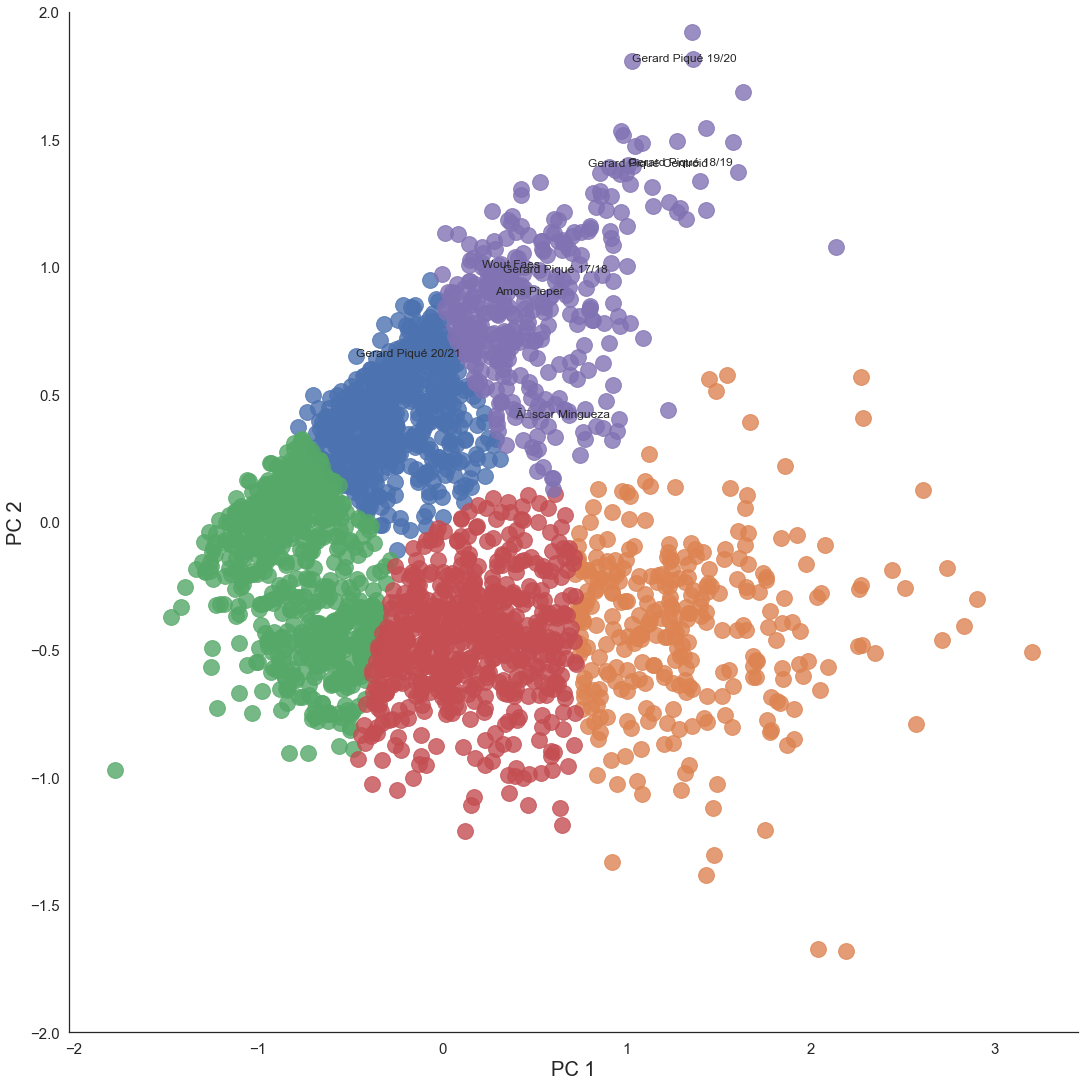

In [74]:
# Visualise the clustering, now including Piqué data points
sns.set(style="white")
ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
fit_reg=False, size = 15, scatter_kws={"s": 250})
texts = []
for x, y, s in zip(reduced_2021_u23_cheap.x, reduced_2021_u23_cheap.y, reduced_2021_u23_cheap.name):
    texts.append(plt.text(x, y, s))

plt.annotate("Gerard Piqué 17/18", (pique_x_1718, pique_y_1718))
plt.annotate("Gerard Piqué 18/19", (pique_x_1819, pique_y_1819))
plt.annotate("Gerard Piqué 19/20", (pique_x_1920, pique_y_1920))
plt.annotate("Gerard Piqué 20/21", (pique_x_2021, pique_y_2021))
plt.annotate("Gerard Piqué Centroid", (pique_x_centroid, pique_y_centroid))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)
plt.show()

From the eye test, we can see that both Wout Faes and Amos Pieper lie very close to the Piqué centroid / 18-19 Piqué performance, with Óscar Mingueza a little further away but still in the same cluster.

From the resulting three man shortlist, the next step is to conduct a deep-dive of their numbers.

---

<a id='section8'></a>

## <a id='#section8'>8. Recruitment Analysis</a>

<a id='section8.1'></a>

### <a id='#section8.1'>8.1. Metrics of Interest
Depending on the position and the interpretation of a position, the qualities required in a potential recruit need to be carefully selected during the assessment process. 

Gerard Piqué is a ball-playing center back that plays a progressive style of football. Therefore, for this task, I will be looking to identify central defenders with these qualities.

Defensive metrics such as Unpressured Long Balls and Clearances, that might be deemed a good measure of performance for a standard central defender, may not be as well-suited as part of the recruitment process for a more progressive central defender that plays in the style of Pique, with metrics such as Completed Progressive Passes and Carries and Under Pressure Pass Completion being more suitable.

As part of the recruitment analysis, each of the three shortlisted players are measured with the following twelve attributes, based on the standard StatsBomb Knutson radar, amended with some more ball-playing metrics. These are then visualised as radars, to compare the numbers of the players against Pique.

| No.     | Variable     |Description    | In/Out-of-possession    |
|------|------|-----|-----|
| 1    | `Cmp_p90`     | **Passes Completed per 90 minutes **.    | In-possession    |
| 2    | `Prog_p90`    | **Progressive Passes per 90 minutes **. Completed passes that move the ball towards the opponent's goal at least 10 yards from its furthest point in the last six passes, or any completed pass into the penalty area. Excludes passes from the defending 40% of the pitch     | In-possession     |
| 3     | `Cmp%`    | **Pass Completion Percentage per 90 minutes **. Minimum 30 minutes played per squad game to qualify as a leader    | In-possession    |
| 4    | `Press_p90`    | **Passes made while under pressure from opponent per 90 minutes **.    | In-possession     |
| 5    | `Carries_p90`    | **Number of times the player controlled the ball with their feet per 90 minutes **.    | In-possession     |
| 6     | `PrgDist_p90`    | **Progressive Distance**. Total distance, in yards, that completed passes have traveled towards the opponent's goal per 90 minutes . Note: Passes away from opponent's goal are counted as zero progressive yards.    | In-possession    |
| 7     | `TotDist_p90`    | **Total distance, in yards, that completed passes have traveled in any direction per 90 minutes **.    | In-possession    |
| 8     | `npxG+xA`    | **Non-Penalty Expected Goals plus xG Assisted per 90 minutes**. Minimum 30 minutes played per squad game to qualify as a leader    | In-possession     |
| 9    | `SCA_p90`    | **Shot-Creating Actions**. The two offensive actions directly leading to a shot, such as passes, dribbles and drawing fouls per 90 minutes . Note: A single player can receive credit for multiple actions and the shot-taker can also receive credit.    | In-possession     |
| 10    | `Tkl+Int`    | **Number of players tackled plus number of interceptions**.    | Out-of-possession     |
| 11    | `Tkl%`    | **Percentage of dribblers tackled**. Dribblers tackled divided by dribblers tackled plus times dribbled past.     | Out-of-possession     |
| 12    | `Won%`    | **Percentage of aerials battles successfully contested**.     | Out-of-possession     |

<a id='section8.2'></a>

### <a id='#section8.2'>8.2. Radars
What is a radar? To quote [Ted Knutson](https://twitter.com/mixedknuts) "It’s a way of visualizing a large number of stats at one time. In our case, the radars specifically deal with player stats". Radar charts are also known as spider charts or graphs because they can look like they make a spider web.

In football analysis and video games, radar charts have been popularised in a number of places, from the FIFA series, to Ted Knutson’s innovative ways of displaying player data.

Radar charts are an engaging way to show data that typically piques more attention than a bar chart although you can often use both of these to show the same data.

For more information on StatsBomb radars: https://statsbomb.com/2018/08/new-data-new-statsbomb-radars/.

<a id='section8.3'></a>

### <a id='#section8.3'>8.3. Recruitment Shortlist Data Deep-dive
The next section goes into detail for each of the three selected players, looking at key bio, valuation, contractual and salary information, as well as player performance using radars, that are compared to Gerard Piqué. Finally, from a data perspective, the siotability andviability of the candidate is summarised.

<a id='section8.3.1'></a>

#### <a id='#section8.3.1'>8.3.1. Wout Faes

##### Player data

In [276]:
# Define summary columns
cols_summary = ['player_name_fbref',
                'Age',
                'TmPos',
                'Squad',
                'Nationality Cleaned',
                'foot',
                'height',
                'MP',
                'Min',
                'market_value_eur',
                'weekly_gross_base_salary_gbp',
                'years_until_contract_expiry'
               ]

# Define player name
player_1 = 'Wout Faes'

# Filter dataset for player
df_player_1 = df_players[(df_players['player_name_fbref'] == player_1) &
                         (df_players['season'] == '2020/2021')
                        ]

## Select columns of interest
df_player_1 = df_player_1[cols_summary]

# Reset index
df_player_1 = df_player_1.reset_index(drop=True)

# Display DataFrame
df_player_1

,player_name_fbref,Age,TmPos,Squad,Nationality Cleaned,foot,height,MP,Min,market_value_eur,weekly_gross_base_salary_gbp,years_until_contract_expiry
0,Wout Faes,22,Centre-Back,Reims,Belgium,right,187.0,33,2899,3000000.0,8974.0,2.0


*    **Name**: Wout Faes
*    **Age**: 22
*    **Position**: Center Back
*    **Team**: Stade Rennes
*    **Nationality**: Belgium
*    **Foot**: Right
*    **Height**: 187cm
*    **Matched Played** (20/21): 33
*    **Minutes Played** (20/21): 2,899
*    **Estimated Value (€), as per TransferMarkt** (December 2020): €3.0M
*    **Weekly Gross Base Salary**: €8,077
*    **Year Until Contract Expiry**: 2

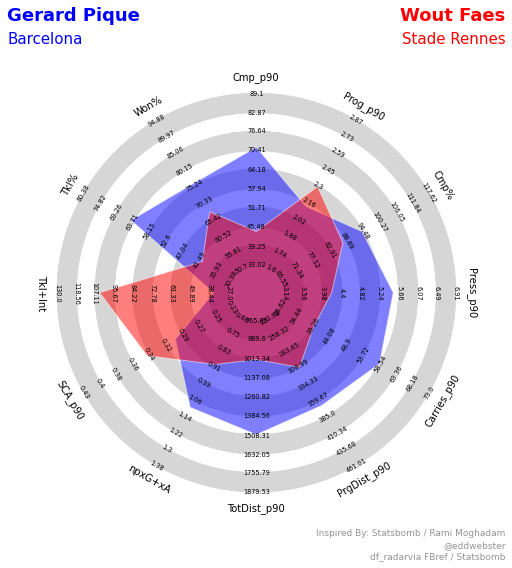

In [277]:
# Create a radar using the custom 'create_2p_radar' function (defined at start of notebook)
create_2p_radar(df_players,
                season='2020/2021',
                player_1_name='Gerard Pique',
                player_1_colour='blue',
                player_1_team='Barcelona',
                player_2_name='Wout Faes',
                player_2_colour='red',
                player_2_team='Stade Rennes'
               )

##### Analysis

<a id='section8.3.2'></a>

#### <a id='#section8.3.2'>8.3.2. Amos Pieper

##### Player data

In [278]:
# Define player name
player_2 = 'Amos Pieper'

# Filter dataset for player
df_player_2 = df_players[(df_players['player_name_fbref'] == player_2) &
                         (df_players['season'] == '2020/2021')
                        ]

## Select columns of interest
df_player_2 = df_player_2[cols_summary]

# Reset index
df_player_2 = df_player_2.reset_index(drop=True)

# Display DataFrame
df_player_2

,player_name_fbref,Age,TmPos,Squad,Nationality Cleaned,foot,height,MP,Min,market_value_eur,weekly_gross_base_salary_gbp,years_until_contract_expiry
0,Amos Pieper,22,Centre-Back,Arminia,Germany,right,192.0,30,2682,3500000.0,1709.0,0.0


*    **Name**: Amos Pieper
*    **Age**: 22
*    **Position**: Center Back
*    **Team**: Arminia Bielefeld
*    **Nationality**: Germany
*    **Foot**: Right
*    **Height**: 192cm
*    **Matched Played** (20/21): 30
*    **Minutes Played** (20/21): 2,682
*    **Estimated Value (€), as per TransferMarkt** (December 2020): €3.5M 
*    **Weekly Gross Base Salary**: €1,538
*    **Year Until Contract Expiry**: 0

##### Radar

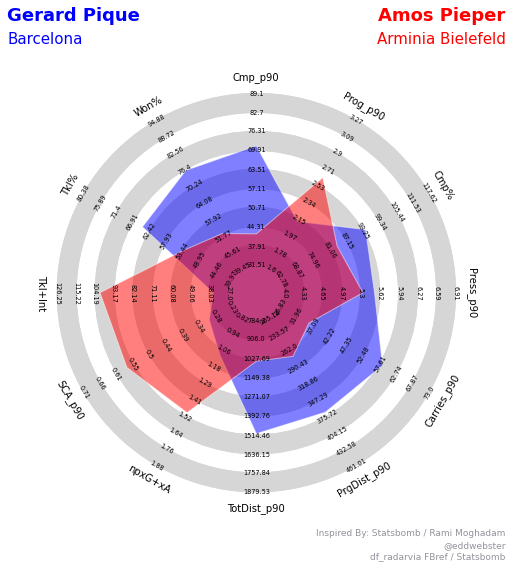

In [279]:
# Create a radar using the custom 'create_2p_radar' function (defined at start of notebook)
create_2p_radar(df_players,
                season='2020/2021',
                player_1_name='Gerard Pique',
                player_1_colour='blue',
                player_1_team='Barcelona',
                player_2_name='Amos Pieper',
                player_2_colour='red',
                player_2_team='Arminia Bielefeld',
               )

##### Analysis

<a id='section8.3.3'></a>

#### <a id='#section8.3.3'>8.3.3. Óscar Mingueza

##### Player data

In [280]:
# Define player name
player_3 = 'Oscar Mingueza'

# Filter dataset for player
df_player_3 = df_players[(df_players['player_name_fbref'] == player_3) &
                         (df_players['season'] == '2020/2021')
                        ]

## Select columns of interest
df_player_3 = df_player_3[cols_summary]

# Reset index
df_player_3 = df_player_3.reset_index(drop=True)

# Display DataFrame
df_player_3

,player_name_fbref,Age,TmPos,Squad,Nationality Cleaned,foot,height,MP,Min,market_value_eur,weekly_gross_base_salary_gbp,years_until_contract_expiry
0,Oscar Mingueza,21,Centre-Back,Barcelona,Spain,right,184.0,27,1901,200000.0,4701.0,1.0


*    **Name**: Óscar Mingueza
*    **Age**: 21
*    **Position**: Center Back
*    **Team**: Barcelona
*    **Nationality**: Spain
*    **Foot**: Right
*    **Height**: 184cm
*    **Matched Played** (20/21): 27
*    **Minutes Played** (20/21): 1,901
*    **Estimated Value (€), as per TransferMarkt** (December 2020): €2.0M
*    **Weekly Gross Base Salary**: €4,231
*    **Year Until Contract Expiry**: 2

##### Radar

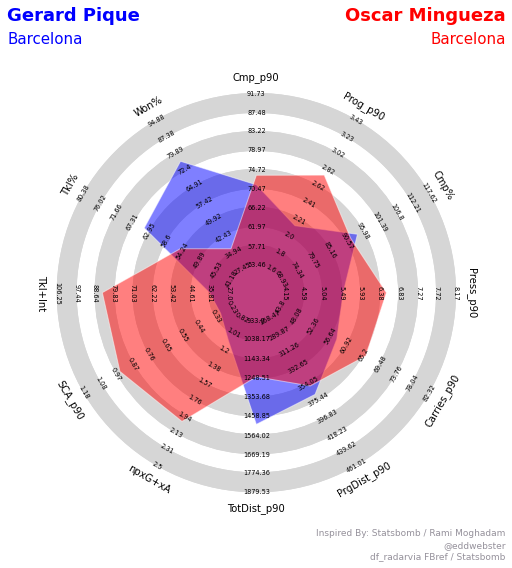

In [281]:
# Create a radar using the custom 'create_2p_radar' function (defined at start of notebook)
create_2p_radar(df_players,
                season='2020/2021',
                player_1_name='Gerard Pique',
                player_1_colour='blue',
                player_1_team='Barcelona',
                player_2_name='Oscar Mingueza',
                player_2_colour='red',
                player_2_team='Barcelona',
               )

##### Analysis

---

<a id='section9'></a>

## <a id='#section9'>9. Summary</a>
This notebook analyses an engineered dataset of aggregated player performance from [FBref](https://fbref.com/en/) via [StatsBomb](https://statsbomb.com/), enriched with player bio and valuation data from [TransferMarkt](https://www.transfermarkt.co.uk/) and player salaries data from [Capology](https://www.capology.com/), using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames, [matplotlib](https://matplotlib.org/stable/index.html) for data visualisation, and [scikit-learn](https://scikit-learn.org/stable/) for Machine Learning,  to conduct some basic clustering using PCA and K-Means Clustering, to find the players with similar output to Gerard Piqué, in an attempt to find players that as part of a recruitment strategy for Parma Calcio 1913.

The outcome of this analysis was to identify the following three candidates that produce similar data points to Gerard Piqué, whilst also meeting age, playing time, and budget requirements.
1.    Wout Faes [[TransferMarkt](https://www.transfermarkt.co.uk/wout-faes/profil/spieler/292808)] [[FBref](https://fbref.com/en/players/9c221d14/Wout-Faes)]
2.    Amos Pieper [[TransferMarkt](https://www.transfermarkt.co.uk/amos-pieper/profil/spieler/334221)] [[FBref](https://fbref.com/en/players/526ea7cc/Amos-Pieper)]
3.    Óscar Mingueza [[TransferMarkt](https://www.transfermarkt.co.uk/oscar-mingueza/profil/spieler/331505)] [[FBref](https://fbref.com/en/players/056269d7/Oscar-Mingueza)]

---

<a id='section10'></a>

## <a id='#section10'>10. Next Steps</a>
Suggested next steps for this analysis with more time and data include:
Video analysis. Work with the performance analysts to compare what is seen in the data with the footage. 
*    Video analysis. Work with the performance analysts to compare what is seen in the data with the footage. Are the players suggested as having Gerard Piqué qualities actually showing it on the pitch regarding progressive passing and dribbles, winning aerial balls, etc.
*    Create a 'Likeliness' Score. Currently, the data just measures the proximity to the cluster and orders by closest to furthest. This could be converted into a percentage score, of how similar that player is to comparison player.
*    Better identify the traits that cause Piqué to play the way he does. Notable research in this field has been carried out by [Paul Power](https://twitter.com/counterattack9) and [Patrick Lucey](https://twitter.com/patricklucey) of StatsPerform [[link](https://www.youtube.com/watch?v=lRg0BCLeitM)].
*    Implement more, complex metrics such as Completed Passes Greater than Expected. Through the application of ML classification algorithms and Event and/or Tracking data, models can be trained to determine the likelihood of a pass being completed which in turn, can be used to determine metrics such as the number of passes completed above the level of expectation.
*    Train player valuation models to better estimate a player’s market value. TransferMarkt uses a ”wisdom-of-the-crowds” approach, however, models can be created from different datasets such as player recorded transfers and Capology player salaries, to better estimate these transfer values. An example model that does this is the DePO model by [Sam Goldberg](https://twitter.com/SamGoldberg1882) (New York Red Bulls) and [Mike Imburgio](https://twitter.com/mimburgio) of American Soccer Analysis [[link](https://www.americansocceranalysis.com/home/2020/10/26/the-depo-models-bringing-moneyball-to-professional-soccer)].

---

<a id='section11'></a>

## <a id='#section11'>11. References</a>

#### Data and Web Scraping
*    [FBref](https://fbref.com/) for the data to scrape
*    FBref statement for using StatsBomb's data: https://fbref.com/en/statsbomb/
*    [StatsBomb](https://statsbomb.com/) providing the data to FBref.

#### Clustering

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)